In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../Code')
from utils import save_adata, read_adata
from geneset_testing import load_geneset, fishertestbygep, mwtestbygep_ZES


import palettable
from IPython.display import display

from joblib import parallel_backend

from sklearn.preprocessing import scale
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

from matplotlib import gridspec

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(scanpy=True, dpi=80, vector_friendly=False, ipython_format='png')

np.random.seed(14)

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
import os

adir = '../../../data/ExVivo/Seqwell/'
project_name = 'exvivo2_20200318_mmul8_V4'
gcs = False
abase = os.path.join(adir, project_name)

count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'
abase

results_dir = '../../../results'

In [4]:
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

## Make basic plots of Ebola abundance levels in monocytes

In [225]:
umap_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.EBOVcalls.UMAPdata.tsv'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
exvebovdat = pd.read_csv(umap_file, sep='\t', index_col=0)
exvebovdat.head()

,batch,array_id,run,BP,treatment_full,treatment,MOI,animal,hour,condition,...,Ebola_Positive,UMAP_1,UMAP_2,Subclustering_clean,MX1,cluster_color,condition_color,animal_color,log10_EBOV_TPT_Clean,ifn_score
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAAAATGCC,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,False,8.857688,-7.039243,Monocyte,-0.450777,#2CA02C,#98D9E4,#5F9ED1,0.0,-0.017244
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTCGTGGT,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,False,-6.557926,-4.902356,T CD4+ ITGB1lo SELLhi,-0.450777,#FCCE03,#98D9E4,#5F9ED1,0.0,-0.016335
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTGCCTTG,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,False,-3.328095,-1.162756,T CD4+ CXCR5hi,-0.450777,#FF9896,#98D9E4,#5F9ED1,0.0,0.075220
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAATCATTCTC,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,False,7.398421,4.243689,B Naive,-0.450777,#1F77B4,#98D9E4,#5F9ED1,0.0,0.197849
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAACACTATTTT,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,False,10.125947,5.166697,B Memory,-0.450777,#AEC7E8,#98D9E4,#5F9ED1,0.0,0.175090


In [226]:
exvebovdat.columns

Index(['batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI',
       'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes',
       'log_count', 'log10_EBOV_TPT', 'EBOV_counts', 'percent_EBOV',
       'Subclustering', 'SubclusteringGroup', 'Ebola_Positive', 'UMAP_1',
       'UMAP_2', 'Subclustering_clean', 'MX1', 'cluster_color',
       'condition_color', 'animal_color', 'log10_EBOV_TPT_Clean', 'ifn_score'],
      dtype='object')

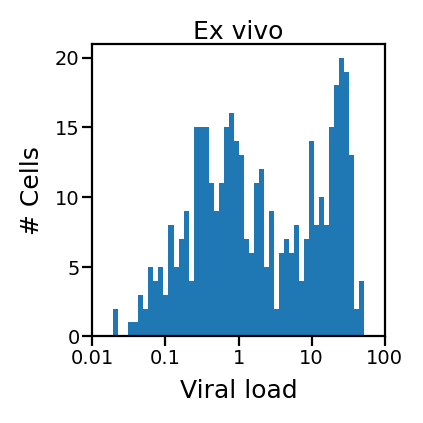

In [227]:
fig = plt.figure(constrained_layout=True, figsize=(2., 2.), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.95, top=.92)
ax = fig.add_subplot(gs[0],
                     xlabel='Viral load', ylabel='# Cells',
                     title='Ex vivo')
ax.set_title('Ex vivo', pad=0)

ind = (exvebovdat['SubclusteringGroup']=='Mono') & (exvebovdat['Ebola_Positive']==True) & exvebovdat['condition'].isin(['live.H004', 'live.H024'])
#ind = (exvebovdat['SubclusteringGroup']=='Mono') & (exvebovdat['EBOV_counts']>0) & exvebovdat['condition'].isin(['live.H004', 'live.H024'])




_ = ax.hist(np.log10(exvebovdat.loc[ind, 'percent_EBOV']), bins=50)


ax.set_xticks([-4, -3, -2, -1,0])
ax.set_xticklabels(['0.01', '0.1', '1', '10','100'])
ax.grid(False)

figure_file = os.path.join(results_dir, "EbolaPercentTranscripts.ExVivo.Histogram.pdf")
fig.savefig(figure_file, dpi=200)

In [228]:
exvebovdat.loc[ind, 'percent_EBOV'].max()

0.52268827

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


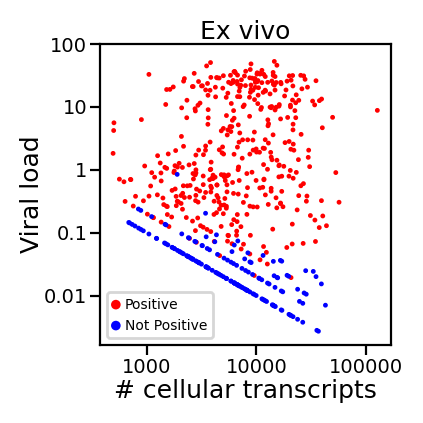

In [8]:
fig = plt.figure(constrained_layout=True, figsize=(2.0, 2.0), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.95, top=.95)
ax = fig.add_subplot(gs[0],
                     ylabel='% EBOV', xlabel='Total transcripts detected',
                     title='')

ind = (exvebovdat['SubclusteringGroup']=='Mono') & (exvebovdat['EBOV_counts']>0) & exvebovdat['condition'].isin(['live.H004', 'live.H024']) & (exvebovdat['Ebola_Positive']==True)
ax.scatter(exvebovdat.loc[ind, 'log_count'], exvebovdat.loc[ind, 'percent_EBOV'].apply(np.log10), s=3, edgecolor='None', color='r', label='Positive')
ind = (exvebovdat['SubclusteringGroup']=='Mono') & (exvebovdat['EBOV_counts']>0) & exvebovdat['condition'].isin(['live.H004', 'live.H024']) & (exvebovdat['Ebola_Positive']==False)
ax.scatter(exvebovdat.loc[ind, 'log_count'], exvebovdat.loc[ind, 'percent_EBOV'].apply(np.log10), s=3, edgecolor='None', color='b', label='Not Positive')

ax.set_xticks([3, 4, 5])
ax.set_xticklabels([1000, 10000, 100000])

ax.set_ylabel('Viral load', labelpad=0)
ax.set_xlabel('# cellular transcripts', labelpad=1)

ax.set_yticks([-4, -3, -2, -1, 0])
ax.set_yticklabels(['0.01', '0.1', '1', '10', '100'])
ax.legend(markerscale=2, fontsize=5)
ax.set_title('Ex vivo', pad=0)
ax.grid(False)

figure_file = os.path.join(results_dir, "EbolaPercentVsLogUmi.ExVivo.Scatter.pdf")
fig.savefig(figure_file, dpi=200)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


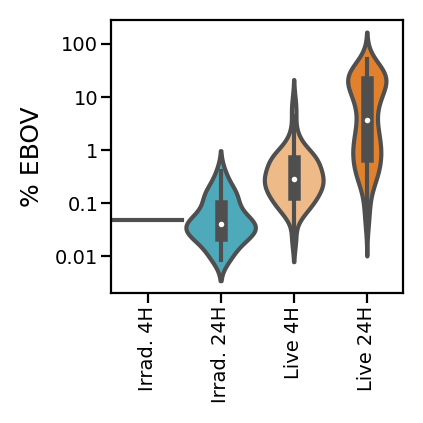

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(2., 2.), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.95, top=.95)
ax = fig.add_subplot(gs[0])

cset = palettable.tableau.GreenOrange_12.hex_colors

#conditions = ['live.H004', 'live.H024', 'irrad.H004', 'irrad.H024', 'media.H004', 'media.H024']
conditions = ['live.H004', 'live.H024', 'irrad.H004', 'irrad.H024']
condition_cmap = {'live.H024':cset[2], 'live.H004':cset[3], 'irrad.H024':cset[4],  'irrad.H004':cset[5], 'media.H024':cset[0], 'media.H004':cset[1]}

ind = (exvebovdat['SubclusteringGroup']=='Mono') & (exvebovdat['Ebola_Positive']==True) & exvebovdat['condition'].isin(conditions)
X = exvebovdat.loc[ind, :]
X['log_percent'] = np.log10(X['percent_EBOV'])
order = ['irrad.H004', 'irrad.H024', 'live.H004', 'live.H024']
sns.violinplot(x='condition', y='log_percent', data=X, ax=ax, width=.95, order=order,
               palette=condition_cmap)
ax.set_xlim((-0.5, 3.5))
ax.set_xticklabels(['Irrad. 4H', 'Irrad. 24H', 'Live 4H', 'Live 24H'], rotation=90)
ax.set_xlabel('')
ax.set_yticks([-4, -3, -2, -1, 0])
ax.set_yticklabels(['0.01', '0.1', '1', '10','100'])
ax.set_ylabel('% EBOV')
ax.grid(False)

figure_file = os.path.join(results_dir, "EbolaPercent4Hvs24H.ExVivo.Violin.pdf")
fig.savefig(figure_file, dpi=200)

In [192]:
cset = palettable.tableau.ColorBlind_10.hex_colors

exvebovdat['animal_rename'] = exvebovdat['animal'].replace({'EV0003':'NHP1', 'EV0004':'NHP2'})
animal_cmap = {'NHP1':cset[4], 'NHP2':cset[5]}


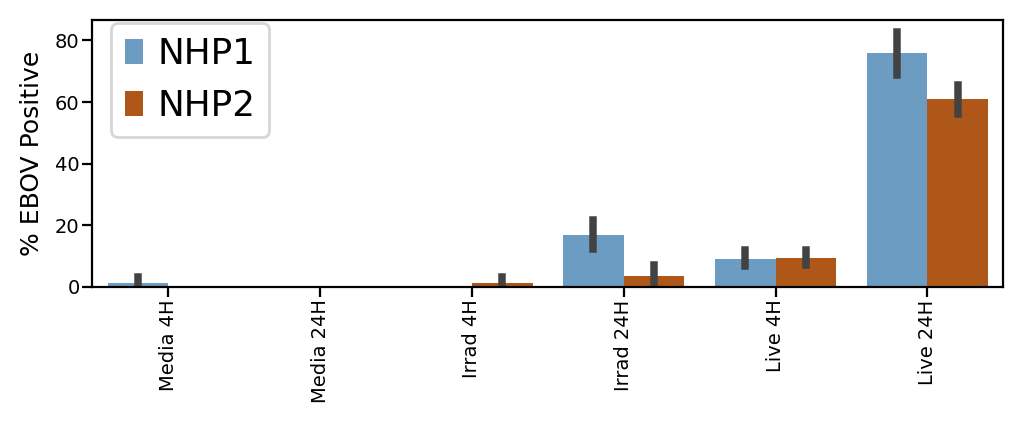

In [193]:
fig = plt.figure(constrained_layout=True, figsize=(5,2), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.98, top=.98)
ax = fig.add_subplot(gs[0])

order = ['media.H004', 'media.H024', 'irrad.H004', 'irrad.H024', 'live.H004', 'live.H024']
labels = ['Media 4H', 'Media 24H', 'Irrad 4H', 'Irrad 24H', 'Live 4H', 'Live 24H']

ind = exvebovdat['SubclusteringGroup']=='Mono'
exvebovdat['Ebola_Positive_100'] = exvebovdat['Ebola_Positive'].astype(int)*100
sns.barplot(x='condition', hue='animal_rename', y='Ebola_Positive_100',
               data=exvebovdat.loc[ind,:], ax=ax, order=order,
             palette=animal_cmap)
ax.set_xticklabels(labels, rotation=90)
ax.legend(loc=(.02,.56))
ax.set_ylabel('% EBOV Positive')
ax.set_xlabel('')
ax.grid(False)

figure_file = os.path.join(results_dir, "EBOVinfected.ExVivo.PerConditionAnimal.Barplot.pdf")
fig.savefig(figure_file, dpi=200)

In [195]:
ct = pd.crosstab(exvebovdat.loc[ind, 'condition'], exvebovdat.loc[ind, 'Ebola_Positive'])
ct.div(ct.sum(axis=1), axis=0)

Ebola_Positive,False,True
condition,,
irrad.H004,0.994253,0.005747
irrad.H024,0.881890,0.118110
live.H004,0.907427,0.092573
live.H024,0.349206,0.650794
media.H004,0.994135,0.005865
media.H024,1.000000,0.000000


## Continuous association differential expression analysis

In [5]:
adat_fn = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.EBOVcalls.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
adata = read_adata(adat_fn, gcs=gcs)

Only considering the two last: ['.EBOVcalls', '.h5ad'].
Only considering the two last: ['.EBOVcalls', '.h5ad'].


In [6]:
adata_raw = sc.AnnData(X=adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)
adata_raw = adata_raw[:,~adata_raw.var['Combined_Blacklist']]

In [8]:
adir_local = '../../../data/ExVivo/Seqwell/'
dedir = os.path.join(adir_local, 'DE_Infection_Continuous')
if not os.path.exists(dedir): os.mkdir(dedir)
    
de_infiles = os.path.join(dedir, 'genefiles')
if not os.path.exists(de_infiles): os.mkdir(de_infiles)
    
de_results = os.path.join(dedir, 'results')
if not os.path.exists(de_results): os.mkdir(de_results)

In [8]:
ind = (adata_raw.obs['SubclusteringGroup']=='Mono') & (adata_raw.obs['condition'].isin(['live.H024'])) &  (adata_raw.obs['log10_EBOV_TPT']>0)

adata_ct = adata_raw[ind,:]
adata_ct.obs['percent_mito_scale'] = scale(adata_ct.obs['percent_mito'])
adata_ct.obs['animal_bin'] = adata_ct.obs['animal'].replace({'EV0003':0, 'EV0004':1})

sc.pp.filter_genes(adata_ct, min_cells=10)
adata_ct.obs['cngeneson'] =  scale((adata_ct.X>0).sum(axis=1)).reshape(-1)        
sc.pp.normalize_per_cell(adata_ct, counts_per_cell_after=10000)
sc.pp.log1p(adata_ct)

X = pd.DataFrame(adata_ct.X.todense(), index=adata_ct.obs.index, columns=adata_ct.var.index).T

outdir = os.path.join(dedir, 'infectedmono_live24')
if not os.path.exists(outdir): os.mkdir(outdir)
    
exprfn = os.path.join(outdir, 'infectedmono_live24.expression.csv')
celldatfn = os.path.join(outdir, 'infectedmono_live24.celldata.csv')
genedatfn = os.path.join(outdir, 'infectedmono_live24.genedata.csv')


X.to_csv(exprfn)
adata_ct.obs.to_csv(celldatfn)
adata_ct.var.to_csv(genedatfn)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
Trying to set attribute `.obs` of view, copying.


filtered out 7440 genes that are detectedin less than 10 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [19]:
ncores =7
testvar = 'log10_EBOV_TPT'
covars = ['cngeneson', 'percent_mito_scale', 'animal_bin']
covarstr = ','.join(covars)



resultsfn = os.path.join(outdir, 'infectedmono.EBOVcontinuous.MitoGenesonAnimal.DE.csv')
cmd = 'Rscript ../../Code/run_mast.R %s %s %s %s %d %s %s' % (exprfn, celldatfn, genedatfn, resultsfn, ncores, testvar, covarstr)
print(cmd)
!{cmd}

Rscript ../../Code/run_mast.R ../../../data/ExVivo/Seqwell/DE_Infection_Continuous/infectedmono_live24/infectedmono_live24.expression.csv ../../../data/ExVivo/Seqwell/DE_Infection_Continuous/infectedmono_live24/infectedmono_live24.celldata.csv ../../../data/ExVivo/Seqwell/DE_Infection_Continuous/infectedmono_live24/infectedmono_live24.genedata.csv ../../../data/ExVivo/Seqwell/DE_Infection_Continuous/infectedmono_live24/infectedmono.EBOVcontinuous.MitoGenesonAnimal.DE.csv 7 log10_EBOV_TPT cngeneson,percent_mito_scale,animal_bin
~log10_EBOV_TPT + cngeneson + percent_mito_scale + animal_bin
`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name et is log-transformed.
 Completed [=====>--------------------------------------]  14% with 0 failures
Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...
 Completed [====

In [9]:
spearman_res = {}
for i in X.index:
    (R,P) = spearmanr(X.loc[i,:], adata_ct.obs['log10_EBOV_TPT'])
    spearman_res[i] = [R,P]

In [10]:
spearman_res = pd.DataFrame.from_dict(spearman_res, columns=['Spearman_R', 'Spearman_P'], orient='index')
spearman_res.head()

,Spearman_R,Spearman_P
CCNF,-0.144450,0.002773
NAGA,-0.035909,0.459242
BET1,0.145302,0.002615
PTPRC,-0.076807,0.113003
EMC7,-0.040430,0.404651


In [9]:
outdir = os.path.join(dedir, 'infectedmono_live24')

resultsfn = os.path.join(outdir, 'infectedmono.EBOVcontinuous.MitoGenesonAnimal.DE.csv')

cont24 = pd.read_csv(resultsfn).sort_values(by='P_H')
cont24.index = cont24['primerid']

(_,q,_,_) = multipletests(cont24['P_H'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
cont24['Q'] = q
cont24.loc[:,'logQ'] = cont24.loc[:,'Q'].apply(np.log10)*-1

In [12]:
cont24.loc['IARS',:]

primerid           IARS
logFC          0.223129
P_H         4.34078e-11
P_C         6.49388e-05
P_D         1.73742e-08
Q           8.41281e-09
logQ            8.07506
Name: IARS, dtype: object

,logFC,P_H,Q,Spearman_R,Spearman_P
primerid,,,,,
STAT1,-0.398625,5.394006e-45,4.913400e-41,-0.619310,1.406124e-46
MX2,-0.347747,6.617508e-29,3.013944e-25,-0.521564,3.687704e-31
MX1,-0.377297,5.074605e-28,1.540819e-24,-0.511975,6.645696e-30
LAP3,-0.386369,8.551089e-28,1.947297e-24,-0.515633,2.229607e-30
GBP2,-0.450149,1.247498e-27,2.272691e-24,-0.518724,8.766976e-31
DYNLL1,0.384405,2.542175e-27,3.859445e-24,0.507986,2.154689e-29
UBE2L6,-0.266005,4.759603e-26,6.193603e-23,-0.509367,1.436431e-29
HSPA5,0.354932,3.955839e-25,4.504217e-22,0.517613,1.227650e-30
HSPA8,-0.249706,9.568280e-23,9.684163e-20,-0.445455,3.328524e-22


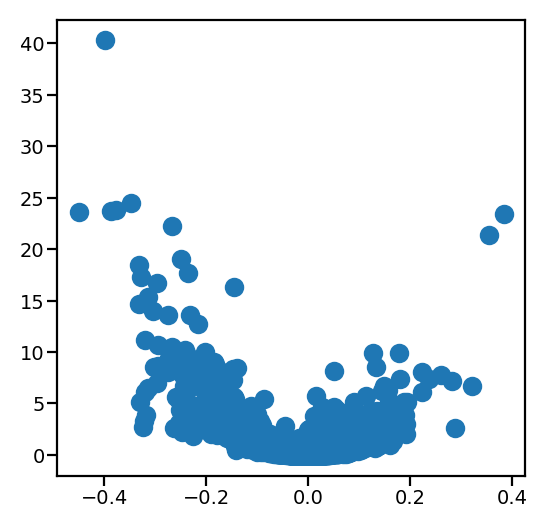

In [105]:
cont24 = pd.merge(left=cont24, right=spearman_res, left_index=True, right_index=True, how='left')

(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
ax.scatter(cont24.loc[:,'logFC'], cont24.loc[:,'Q'].apply(np.log10)*-1)
ax.grid(False)

cont24.loc[:,['logFC', 'P_H', 'Q', 'Spearman_R', 'Spearman_P']].iloc[:20,:]




In [106]:
gsetfn = '../../../data/Genesets/msigdb/c2andh.all.v6.2.symbols.gmt'
gset_c2andH, allgenes = load_geneset(gsetfn,  genes=list(cont24.index), minsize=10)

literature_interferon = gset_c2andH['HECKER_IFNB1_TARGETS'].union(gset_c2andH['BROWNE_INTERFERON_RESPONSIVE_GENES']).union(gset_c2andH['MOSERLE_IFNA_RESPONSE']).union(gset_c2andH['HALLMARK_INTERFERON_ALPHA_RESPONSE']).union(gset_c2andH['HALLMARK_INTERFERON_GAMMA_RESPONSE'])
print(len(literature_interferon))

cont24['ISG'] = cont24['primerid'].isin(literature_interferon)
cont24.loc['MNDA', 'ISG'] = True
cont24['Category'] = 'Other'
cont24.loc[cont24['ISG']==True, 'Category'] = 'ISG'


213


In [107]:
cont24.head()

,primerid,logFC,P_H,P_C,P_D,Q,logQ,Spearman_R,Spearman_P,ISG,Category
primerid,,,,,,,,,,,
STAT1,STAT1,-0.398625,5.394006e-45,5.773590e-25,5.729745e-23,4.913400e-41,40.308618,-0.619310,1.406124e-46,True,ISG
MX2,MX2,-0.347747,6.617508e-29,7.102176e-06,1.195997e-25,3.013944e-25,24.520865,-0.521564,3.687704e-31,True,ISG
MX1,MX1,-0.377297,5.074605e-28,4.741610e-10,1.132620e-20,1.540819e-24,23.812248,-0.511975,6.645696e-30,True,ISG
LAP3,LAP3,-0.386369,8.551089e-28,3.880228e-20,2.325402e-10,1.947297e-24,23.710568,-0.515633,2.229607e-30,True,ISG
GBP2,GBP2,-0.450149,1.247498e-27,2.455056e-12,5.168235e-18,2.272691e-24,23.643460,-0.518724,8.766976e-31,True,ISG


In [108]:
box_height=2.2
box_width=2.2
left_space = .15
right_space = .98
bottom_space = .13
top_space = .9

DYNLL1 0.02178627884464571
HSPA5 0.02178627884464571
GTF2A1 0.0500923232713697
DDIT3 0.04510652840583888
PPARG [-0.03, 1.0, 'right', 'center']
PPARG 0.03970634841526181
IARS [0.02, 2, 'center', 'bottom']
IARS 0.0500923232713697
NFE2L1 0.050092323271369706
FAM107B [0, -1, 'center', 'top']
FAM107B 0.02255326420291944
FTL [-0.02, 1.3, 'right', 'center']
FTL 0.03652752363883922
HSPA9 [-0.06, 0.5, 'right', 'center']
HSPA9 0.06632450485771892
SQSTM1 [0.02, 1, 'left', 'center']
SQSTM1 0.03135748191585773
ENSMMUG00000044793 0.021786278844645696
STAT1 0.02178627884464571
MX2 0.02178627884464571
MX1 [0, 2, 'center', 'bottom']
MX1 0.04510652840583888
LAP3 0.013531958521751698
GBP2 0.01127663210145972
UBE2L6 0.021786278844645682
HSPA8 0.021786278844645682
IRF7 0.02178627884464571
OAS2 0.021786278844645682
GIMAP4 0.03135748191585773
IFIT2 [0.02, -1, 'left', 'center']
IFIT2 0.03135748191585773
TNFSF13B 0.021786278844645682
FPR3 0.02178627884464571
IFIT1 0.03135748191585773
TGFBI 0.02178627884464571


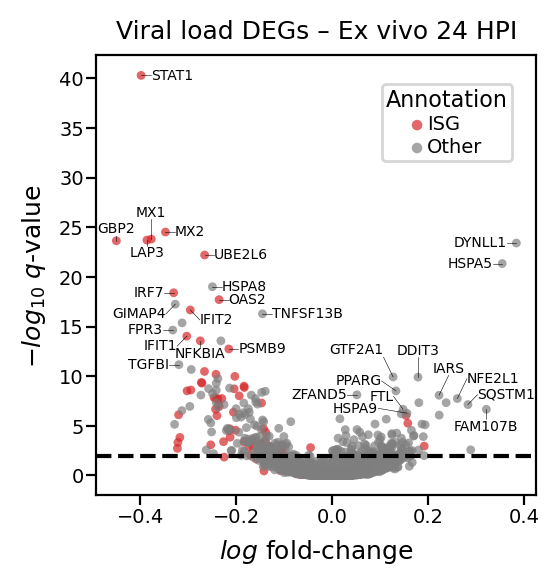

In [109]:
colors = palettable.tableau.Tableau_10.hex_colors
cat2color = {'Mac. Up':colors[0], 'Mac. Down':colors[1], 'Other':colors[7], 'ISG':colors[3]}

ax_width = box_width
fig_width = ax_width/(right_space-left_space)
ax_height = box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(1, 1, fig,
                       left_space, bottom_space, right_space,top_space)



ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=True)


order = ['ISG', 'Other']
xvar = 'logFC'
yvar = 'logQ'
for k in order:
    g = cont24.loc[cont24['Category']==k, :]
    ax.scatter(g[xvar], g[yvar], label=k, s=10,
               edgecolor='None', alpha=.7, color=cat2color[k])
    
ax.grid(False)
leg = ax.legend(loc=(.65, .76), fontsize=7,
                markerscale=1.2, title='Annotation',
                title_fontsize=8,handletextpad=0.25,
                labelspacing=.2, borderpad=.2)
ax.set_xlabel('$log$ fold-change')
ax.set_ylabel('$-log_{10}$ $q$-value')
ax.set_title('Viral load DEGs – Ex vivo 24 HPI')

default_x_shift = 0
default_y_shift = .5
default_ha='center'
default_va='bottom'
labfontsize=5


ordered = cont24.loc[cont24[xvar]>0,:].sort_values(by=yvar, ascending=False)
up_to_label = list(ordered.index[ordered[yvar]>9]) + ['PPARG', 'IARS', 'NFE2L1', 'FAM107B', 'FTL', 'HSPA9', 'SQSTM1', 'ENSMMUG00000044793']

ordered = cont24.loc[cont24[xvar]<0,:].sort_values(by=yvar, ascending=False)
down_to_label = list(ordered.index[ordered[yvar]>16]) + ['FPR3', 'IFIT1', 'TGFBI', 'NFKBIA', 'PSMB9']

rename = {'ENSMMUG00000019251':'GBP3', 'ENSMMUG00000020005':'SLC23A2',
          'ENSMMUG00000014256':'TMSB4X', 'ENSMMUG00000044793':'ZFAND5'}
genes_to_label = up_to_label + down_to_label

upshift = 2.
downshift = -1.

params = {
'above':{'x_shift':0, 'y_shift':upshift, 'ha':'center', 'va':'bottom'},
'right':{'x_shift':.02, 'y_shift':0., 'ha':'left', 'va':'center'},
'left':{'x_shift':-.02, 'y_shift':0., 'ha':'right', 'va':'center'},
'below':{'x_shift':0, 'y_shift':-.6, 'ha':'center', 'va':'top'},
'upper-right':{'x_shift':.02, 'y_shift':upshift, 'ha':'left', 'va':'center'},
'lower-right':{'x_shift':.02, 'y_shift':downshift, 'ha':'left', 'va':'top'},
'upper-left':{'x_shift':-.02, 'y_shift':upshift, 'ha':'right', 'va':'bottom'},
'lower-left':{'x_shift':-.02, 'y_shift':downshift, 'ha':'right', 'va':'center'},
}

category = {
'above':['DDIT3'],
'right':[ 'STAT1', 'TXN', 'UBE2L6', 'MX2', 'HSPA8', 'TUBA1B', 'OAS2', 'TNFSF13B', 'PSMB9'],
'left':['HSPA5', 'DYNLL1', 'ENSMMUG00000044793', 'ENSMMUG00000020005', 'SAMD9L', 'IRF7',
         'FPR3', 'TGFBI'],
'below':['ENSMMUG00000019251', 'LAP3', 'NFKBIA'],
'upper-right':['NFE2L1'],
'lower-right':[],
'upper-left':['GTF2A1'],
'lower-left':['GIMAP4', 'IFIT1'],

}

other_param = {'MX1':[0, 2, 'center', 'bottom'],
               'IFIT2':[.02, -1, 'left', 'center'],
               'KCNA3':[.03, -.8, 'left', 'center'],
               'GPNMB':[-.01, .4, 'center', 'bottom'],
               'IARS':[.02, 2, 'center', 'bottom'],
                'PPARG':[-.03, 1., 'right', 'center'],
               'HSPA9':[-.06, .5, 'right', 'center'],
               'FTL':[-.02, 1.3, 'right', 'center'],
               'FAM107B':[0, -1, 'center', 'top'],
               'SQSTM1':[.02, 1, 'left', 'center'],
                'ENSMMUG00000014256':[.05, 1., 'left', 'center']}




gene2cat = {g:c for c in category.keys() for g in category[c]}
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xwidth = xlim[1]-xlim[0]
ywidth = ylim[1]-ylim[0]

for g in genes_to_label:

    if g in other_param:
      (x_shift,y_shift,ha,va) = other_param[g]
      print(g, other_param[g])

    elif g in gene2cat:
      x_shift = params[gene2cat[g]]['x_shift']
      y_shift = params[gene2cat[g]]['y_shift']
      ha = params[gene2cat[g]]['ha']
      va = params[gene2cat[g]]['va']
    else:
      x_shift = default_x_shift
      y_shift = default_y_shift
      ha = default_ha
      va = default_va
      #continue



    if g in rename:
      tolab = rename[g]
    else:
      tolab = g

    ax.text(cont24.loc[g, xvar]+x_shift, cont24.loc[g, yvar]+y_shift,
          tolab, fontsize=labfontsize, va=va, ha=ha)

    yline = [cont24.loc[g, yvar], cont24.loc[g, yvar]+y_shift]
    xline = [cont24.loc[g, xvar], cont24.loc[g, xvar]+x_shift]

    dist = np.sqrt(((xline[1]-xline[0]) / xwidth)**2 + ((yline[1]-yline[0])/ ywidth)**2)
    print(g, dist)
    if (dist>.01):
      ax.plot(xline, yline, color='k', linewidth=.2)

    


qthresh = .01
xlim = ax.get_xlim()
ax.hlines(-1*np.log10(qthresh), xmin=xlim[0], xmax=xlim[1], linestyle='--')
ax.set_xlim(xlim)

figure_file = os.path.join(results_dir, "DifferentialExpression.Exvivo.ViralLoad.Volcano.pdf")
fig.savefig(figure_file, dpi=200)

In [110]:
cont24['Gene_ID'] = adata_raw.var.loc[cont24.index, 'gene_id']

In [188]:
cont24.loc[cont24['logFC']>0,:].head(30)

,primerid,logFC,P_H,P_C,P_D,Q,logQ,Spearman_R,Spearman_P,ISG,...,Match_ID,human_ortholog_name,human_ortholog_percent_confidence,human_ortholog_percent_identity,Match_GeneSym,Statistic,Sig_Down,Sig_Up,Down,Up
primerid,,,,,,,,,,,,,,,,,,,,,
DYNLL1,DYNLL1,0.384405,2.542175e-27,4.886846e-26,8.659261e-04,3.859445e-24,23.413475,0.507986,2.154689e-29,False,...,DYNLL1,DYNLL1,1.0,100.0000,NaN,0.384405,False,True,False,True
HSPA5,HSPA5,0.354932,3.955839e-25,8.680847e-25,9.628776e-03,4.504217e-22,21.346381,0.517613,1.227650e-30,False,...,HSPA5,HSPA5,1.0,100.0000,NaN,0.354932,False,True,False,True
GTF2A1,GTF2A1,0.127233,3.435227e-13,1.894213e-02,5.863298e-13,1.203519e-10,9.919547,0.316187,2.280253e-11,False,...,GTF2A1,GTF2A1,1.0,100.0000,NaN,0.127233,False,True,False,True
DDIT3,DDIT3,0.179136,3.732551e-13,2.837772e-08,2.750187e-07,1.259252e-10,9.899887,0.324509,6.292732e-12,False,...,DDIT3,DDIT3,1.0,97.9167,NaN,0.179136,False,True,False,True
PPARG,PPARG,0.133160,1.335079e-11,3.587717e-05,9.211242e-09,3.040308e-09,8.517082,0.291269,8.535126e-10,False,...,PPARG,PPARG,1.0,99.2079,NaN,0.133160,False,True,False,True
ENSMMUG00000044793,ENSMMUG00000044793,0.051802,3.681341e-11,1.095628e-02,1.132651e-10,7.621214e-09,8.117976,0.256868,7.328069e-08,False,...,ENSMMUG00000044793,nan,NaN,NaN,NaN,0.051802,False,True,False,True
IARS,IARS,0.223129,4.340783e-11,6.493878e-05,1.737425e-08,8.412808e-09,8.075059,0.269820,1.473583e-08,False,...,IARS,IARS1,1.0,92.0761,NaN,0.223129,False,True,False,True
NFE2L1,NFE2L1,0.261298,1.002522e-10,9.589930e-08,2.737931e-05,1.793139e-08,7.746386,0.270957,1.274772e-08,False,...,NFE2L1,NFE2L1,1.0,99.7409,NaN,0.261298,False,True,False,True
SWAP70,SWAP70,0.237943,2.939580e-10,7.052572e-09,1.277391e-03,4.715620e-08,7.326461,0.292606,7.088300e-10,False,...,SWAP70,SWAP70,1.0,99.3162,NaN,0.237943,False,True,False,True


In [112]:
cont24.head().columns

Index(['primerid', 'logFC', 'P_H', 'P_C', 'P_D', 'Q', 'logQ', 'Spearman_R',
       'Spearman_P', 'ISG', 'Category', 'Gene_ID'],
      dtype='object')

In [185]:
cont24.loc[['DYNLL1', 'HSPA5', 'NFE2L1', 'DDIT3', 'IARS'], :]

,primerid,logFC,P_H,P_C,P_D,Q,logQ,Spearman_R,Spearman_P,ISG,...,Match_ID,human_ortholog_name,human_ortholog_percent_confidence,human_ortholog_percent_identity,Match_GeneSym,Statistic,Sig_Down,Sig_Up,Down,Up
primerid,,,,,,,,,,,,,,,,,,,,,
DYNLL1,DYNLL1,0.384405,2.542175e-27,4.886846e-26,8.659261e-04,3.859445e-24,23.413475,0.507986,2.154689e-29,False,...,DYNLL1,DYNLL1,1.0,100.0000,NaN,0.384405,False,True,False,True
HSPA5,HSPA5,0.354932,3.955839e-25,8.680847e-25,9.628776e-03,4.504217e-22,21.346381,0.517613,1.227650e-30,False,...,HSPA5,HSPA5,1.0,100.0000,NaN,0.354932,False,True,False,True
NFE2L1,NFE2L1,0.261298,1.002522e-10,9.589930e-08,2.737931e-05,1.793139e-08,7.746386,0.270957,1.274772e-08,False,...,NFE2L1,NFE2L1,1.0,99.7409,NaN,0.261298,False,True,False,True
DDIT3,DDIT3,0.179136,3.732551e-13,2.837772e-08,2.750187e-07,1.259252e-10,9.899887,0.324509,6.292732e-12,False,...,DDIT3,DDIT3,1.0,97.9167,NaN,0.179136,False,True,False,True
IARS,IARS,0.223129,4.340783e-11,6.493878e-05,1.737425e-08,8.412808e-09,8.075059,0.269820,1.473583e-08,False,...,IARS,IARS1,1.0,92.0761,NaN,0.223129,False,True,False,True


In [113]:
cont24[['primerid', 'Gene_ID', 'logFC', 'P_H', 'Q','Spearman_R', 'Spearman_P', 'ISG']].rename(columns={'P_H':'P', 'primerid':'Gene_Symbol'}).to_csv(os.path.join(results_dir, 'Monocyte_ViralLoad_Exvivo_DEG.tsv'), sep='\t', index=False)

In [114]:
neg_sig = (cont24['logFC']<0) & (cont24['Q']<.05)
neg_sig.value_counts()

False    8845
True      264
dtype: int64

In [115]:
pos_sig = (cont24['logFC']>0) & (cont24['Q']<.05)
pos_sig.value_counts()

False    8898
True      211
dtype: int64

In [116]:
neg_sig = (cont24['logFC'].abs()>np.log(1.3)) & (cont24['Q']<.05)
neg_sig.value_counts()

False    9075
True       34
dtype: int64

In [117]:
np.log(1.3)

0.26236426446749106

In [118]:
neg_sig = (cont24['logFC'].abs()>np.log(1.3)) & (cont24['Q']<.05)
neg_sig.value_counts()

False    9075
True       34
dtype: int64

## Gene set enrichmen testing

In [162]:
cont24['Statistic'] = cont24['logFC'].copy()
cont24.loc[cont24['P_H']>0.1, 'Statistic'] = 0
cont24['Down'] = (cont24['P_H']<.05) & (cont24['logFC']<0)
cont24['Up'] = (cont24['P_H']<.05) & (cont24['logFC']>0)

'''
gsetfn = '../../../data/Genesets/msigdb/c2andh.all.v6.2.symbols.gmt'
gset_c2andH, allgenes = load_geneset(gsetfn,  genes=None, minsize=10)

cont24['Match_ID'] = cont24['primerid'].copy()
genedata = adata_raw.var.loc[cont24.index, :]
cont24['human_ortholog_name'] = genedata['human_ortholog_name'] 
cont24['human_ortholog_percent_confidence'] = genedata['human_ortholog_percent_confidence'] 
cont24['human_ortholog_percent_identity'] = genedata['human_ortholog_percent_identity'] 
ind = ~cont24.index.isin(allgenes) & cont24.loc[:, 'human_ortholog_name'].isin(allgenes)
ind = cont24.index[ind]
cont24.loc[ind, 'Match_ID'] = cont24.loc[ind, 'human_ortholog_name']
vc = cont24['Match_ID'].value_counts()
dups = vc.index[vc>1]

for d in dups:
    inds = cont24.index[cont24['Match_ID']==d]
    matches_genesym = cont24.loc[inds, 'primerid'] == cont24.loc[inds, 'Match_ID']

    if matches_genesym.sum() == 1:
        todrop = inds[~matches_genesym]
        cont24.loc[todrop,'Match_ID'] = '-1'
    else:
        sortedvals = cont24.loc[inds,:].sort_values(by=['human_ortholog_percent_confidence', 'human_ortholog_percent_identity'], ascending=False)
        cont24.loc[sortedvals.index[1:],'Match_GeneSym'] = '-1'
        
totest = cont24.copy()
totest = totest.loc[totest['Match_ID']!= '-1',:]
totest.index = totest['Match_ID']
'''

totest = cont24.copy()
gset_c2andH, allgenes = load_geneset(gsetfn,  genes=totest.index, minsize=10)
totest = totest.loc[allgenes, ['Down', 'Up']]

In [163]:
from geneset_testing import fishertestbygep

In [164]:
gsettest = fishertestbygep(gset_c2andH,  totest)

Down
Up


In [179]:
outfn = os.path.join(results_dir, 'Monocyte_ViralLoad_Exvivo_GenesetEnrichment.tsv')

In [180]:
gsettest = gsettest.sort_values(by=('Up', 'P'))

In [181]:
for c in ['Up', 'Down']:
    (_,q,_,_) = multipletests(gsettest.loc[:,(c, 'P')], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
    gsettest[(c,'Q')] = q
gsettest.sort_index(axis=1, inplace=True)

In [182]:
gsettest.to_csv(outfn, sep='\t')

In [184]:
gsettest['Up'].sort_values(by='P').head(20)

,OR,P,Q
BUYTAERT_PHOTODYNAMIC_THERAPY_STRESS_UP,2.97222,1.42038e-17,4.67589e-14
TIEN_INTESTINE_PROBIOTICS_24HR_DN,5.07648,2.54428e-14,4.18789e-11
BLUM_RESPONSE_TO_SALIRASIB_UP,3.76837,2.45769e-11,2.69691e-08
KRIGE_RESPONSE_TO_TOSEDOSTAT_24HR_UP,2.30048,2.7367e-09,2.2523e-06
PODAR_RESPONSE_TO_ADAPHOSTIN_UP,4.15457,8.11724e-08,5.34439e-05
MARSON_BOUND_BY_FOXP3_STIMULATED,1.95414,2.92211e-07,0.000160326
UDAYAKUMAR_MED1_TARGETS_DN,3.14549,7.34733e-07,0.000345534
HAMAI_APOPTOSIS_VIA_TRAIL_UP,2.15931,9.56521e-07,0.000393608
KRIGE_RESPONSE_TO_TOSEDOSTAT_6HR_UP,1.90869,1.31577e-06,0.000481281
DUTERTRE_ESTRADIOL_RESPONSE_24HR_DN,2.35217,4.24749e-06,0.00139828


In [159]:
gsettest['Sig_Down'].sort_values(by='P').head(50)

,OR,P
HALLMARK_INTERFERON_GAMMA_RESPONSE,13.93,5.07769e-46
BROWNE_INTERFERON_RESPONSIVE_GENES,36.6862,2.93708e-34
HALLMARK_INTERFERON_ALPHA_RESPONSE,18.3385,2.40367e-31
TAKEDA_TARGETS_OF_NUP98_HOXA9_FUSION_3D_UP,16.8966,8.89858e-30
HECKER_IFNB1_TARGETS,20.3465,4.46e-29
BOSCO_INTERFERON_INDUCED_ANTIVIRAL_MODULE,25.8494,2.45842e-28
FULCHER_INFLAMMATORY_RESPONSE_LECTIN_VS_LPS_DN,5.1719,3.15518e-27
ICHIBA_GRAFT_VERSUS_HOST_DISEASE_D7_UP,18.7106,2.92262e-26
MOSERLE_IFNA_RESPONSE,106.899,6.67917e-25
TAKEDA_TARGETS_OF_NUP98_HOXA9_FUSION_10D_UP,12.9314,1.01685e-22


In [71]:
gsettest.loc[gsettest['H']>0,:].sort_values(by='P').head(40)

,H,P
BUYTAERT_PHOTODYNAMIC_THERAPY_STRESS_UP,6.85264,7.24981e-12
TIEN_INTESTINE_PROBIOTICS_24HR_DN,5.68833,1.28289e-08
BLUM_RESPONSE_TO_SALIRASIB_UP,4.76682,1.87153e-06
SMITH_TERT_TARGETS_UP,3.78451,0.000154011
SHEN_SMARCA2_TARGETS_UP,3.74917,0.000177424
HAMAI_APOPTOSIS_VIA_TRAIL_UP,3.54275,0.000395977
DACOSTA_UV_RESPONSE_VIA_ERCC3_DN,3.44975,0.000561105
GRAESSMANN_APOPTOSIS_BY_DOXORUBICIN_DN,3.40187,0.000669261
GARGALOVIC_RESPONSE_TO_OXIDIZED_PHOSPHOLIPIDS_BLUE_UP,3.34604,0.000819759
UDAYAKUMAR_MED1_TARGETS_DN,3.33434,0.000855009


In [72]:
gsettest.loc['KRIGE_AMINO_ACID_DEPRIVATION', :]

H       1.8342
P    0.0666239
Name: KRIGE_AMINO_ACID_DEPRIVATION, dtype: object

## Make continuous trajectory plots

In [229]:
ind = (adata_raw.obs['SubclusteringGroup']=='Mono') & (adata_raw.obs['condition'].isin(['live.H024']))
adata_ct = adata_raw[ind,:]
sc.pp.filter_genes(adata_ct, min_cells=10)
sc.pp.normalize_per_cell(adata_ct, counts_per_cell_after=10000)
sc.pp.log1p(adata_ct)

filtered out 7274 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [230]:
expr = pd.DataFrame(adata_ct.X.todense(), index=adata_ct.obs.index, columns=adata_ct.var.index)
expr.head()


index,CCNF,NAGA,BET1,PTPRC,EMC7,KATNBL1,ADSS,CCDC86,CATSPERE,PTGER2,...,BEX3,ENSMMUG00000049158,ENSMMUG00000049186,ZNF614,ENSMMUG00000049198,ENSMMUG00000049216,STUB1,ENSMMUG00000049226,IER5L,AMMECR1L
EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_Novaseq_20190829_AAAAAGCTTCAC,0.465518,0.0,0.000000,1.747931,0.000000,0.000000,0.465518,0.000000,0.0,1.021917,...,0.0,0.0,0.0,0.000000,1.377302,0.465518,0.465518,0.781926,0.0,0.000000
EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_Novaseq_20190829_AAAAGTCGGCAT,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.433259,0.954037,0.0,0.954037,...,0.0,0.0,0.0,0.000000,1.433259,0.000000,0.000000,0.000000,0.0,0.000000
EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_Novaseq_20190829_AATGACCCCCGT,0.000000,0.0,0.781926,1.935627,0.000000,0.781926,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,2.093599,0.000000,0.781926,0.000000,0.0,0.781926
EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_Novaseq_20190829_ACATAACCCAGT,0.000000,0.0,0.000000,2.108456,0.936277,0.936277,0.709830,0.000000,0.0,0.936277,...,0.0,0.0,0.0,0.000000,1.635998,0.000000,0.709830,0.000000,0.0,0.000000
EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_Novaseq_20190829_AGCGTGGCGTTG,0.000000,0.0,0.000000,1.905211,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,1.905211,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [231]:
obs = adata_ct.obs
obs.head()

,batch,array_id,run,BP,treatment_full,treatment,MOI,animal,hour,condition,...,percent_hbb,leiden,leiden_lab,leiden_lab_group,Subclustering,SubclusteringGroup,Doublet,Soup_Usage,ebola_infection_threshold,Ebola_Positive
EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_Novaseq_20190829_AAAAAGCTTCAC,EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_N...,EV0003.H024.fresh.a1.std.EX2.live-moi1e-1,Novaseq_20190829,88,live-moi1e-1,live,0.1,EV0003,H024,live.H024,...,0.0,16,Mono/DC 2,Mono/DC,Mono 3,Mono,False,0.003370,4,True
EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_Novaseq_20190829_AAAAGTCGGCAT,EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_N...,EV0003.H024.fresh.a1.std.EX2.live-moi1e-1,Novaseq_20190829,88,live-moi1e-1,live,0.1,EV0003,H024,live.H024,...,0.0,16,Mono/DC 2,Mono/DC,Mono 4,Mono,False,0.019039,5,True
EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_Novaseq_20190829_AATGACCCCCGT,EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_N...,EV0003.H024.fresh.a1.std.EX2.live-moi1e-1,Novaseq_20190829,88,live-moi1e-1,live,0.1,EV0003,H024,live.H024,...,0.0,16,Mono/DC 2,Mono/DC,Mono 3,Mono,False,0.006615,4,True
EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_Novaseq_20190829_ACATAACCCAGT,EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_N...,EV0003.H024.fresh.a1.std.EX2.live-moi1e-1,Novaseq_20190829,88,live-moi1e-1,live,0.1,EV0003,H024,live.H024,...,0.0,16,Mono/DC 2,Mono/DC,Mono 3,Mono,False,0.003404,4,True
EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_Novaseq_20190829_AGCGTGGCGTTG,EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_N...,EV0003.H024.fresh.a1.std.EX2.live-moi1e-1,Novaseq_20190829,88,live-moi1e-1,live,0.1,EV0003,H024,live.H024,...,0.0,16,Mono/DC 2,Mono/DC,Mono 8,Mono,False,0.000356,2,True


In [232]:
g0ind = obs['percent_EBOV']>0


expr_g0 = expr.loc[g0ind,:]
expr_0 = expr.loc[~g0ind,:]
percent_ebov = obs.loc[g0ind, 'percent_EBOV']*100
animal = obs['animal']


plotdata_g0 = pd.concat([percent_ebov, expr_g0], axis=1)
plotdata_g0 = plotdata_g0.sort_values(by='percent_EBOV', ascending=True)


windowsize=100
plotdata_g0_windowed_mean = plotdata_g0.rolling(window=windowsize, center=True).mean().dropna()
plotdata_g0_windowed_se = 1.96*(plotdata_g0.rolling(window=windowsize, center=True).std().dropna() / np.sqrt(windowsize))

percent_EBOV_windowed = plotdata_g0_windowed_mean['percent_EBOV']
log_percent_EBOV_windowed = percent_EBOV_windowed.apply(np.log10)

In [233]:
box_ax_width = .8
line_ax_width = 2
leg_ax_width = 1.85
ax_height = 1.8
ax_width = box_ax_width + line_ax_width + leg_ax_width
wspace_frac = .05
wspace = np.mean([box_ax_width, line_ax_width, leg_ax_width])*wspace_frac
right_space = .98
left_space = .1
top_space = .9
bottom_space = .13
fig_width = (ax_width+2*wspace)*(right_space - left_space)
fig_height = ax_height/(top_space-bottom_space)

In [234]:
mean_expr = expr.mean(axis=0)
ind = cont24.index[(cont24['Spearman_P']>.1) & (cont24['Spearman_R']<0)]
mean_expr.loc[ind].sort_values(ascending=True).head(1000).tail(50)

primerid
ENSMMUG00000020473    0.050341
KLRB1                 0.050474
RFC3                  0.050513
ADGRE2                0.050516
ABCD1                 0.050546
FAM129B               0.050573
MUTYH                 0.050661
KCTD13                0.050665
POLR1E                0.050678
SRRD                  0.050791
TSR2                  0.050968
PTRHD1                0.051082
NSUN6                 0.051308
GTDC1                 0.051359
PLS3                  0.051417
CCDC89                0.051419
PRRC2A                0.051436
LMBR1                 0.051588
CD101                 0.051600
CLCN7                 0.051692
ENSMMUG00000039068    0.051729
SARS2                 0.051735
ARID3A                0.051746
ZNF444                0.051868
FAIM                  0.051910
UBALD1                0.051934
NBEAL2                0.051945
TBC1D9                0.051952
POLR2D                0.052019
ZNF689                0.052098
CEP131                0.052145
PSTK                  0.052165

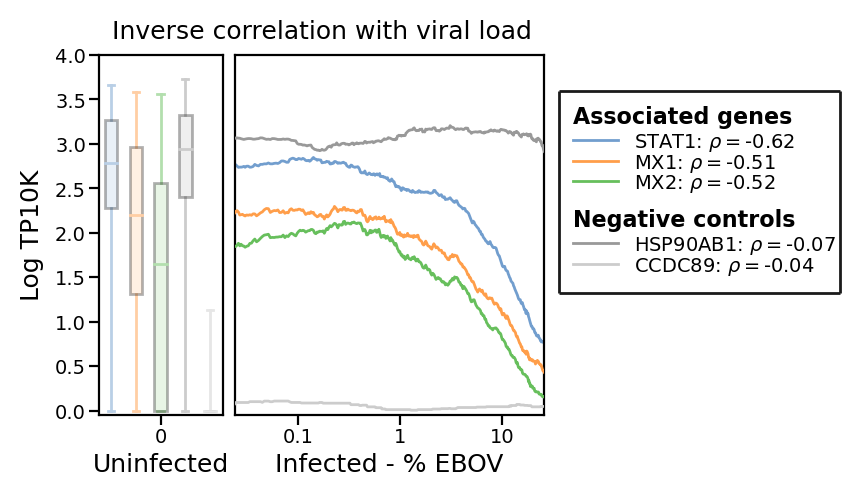

In [235]:
test_genes = ['STAT1', 'MX1', 'MX2']
control_genes = ['HSP90AB1', 'CCDC89']
#control_colors=['#959CA4', '#63676C']
control_colors=['.6', '.8']
test_colors = palettable.tableau.TableauMedium_10.hex_colors[:len(test_genes)]
minebov = log_percent_EBOV_windowed.min()
genes = control_genes + test_genes

fig = plt.figure(figsize=(fig_width,fig_height), dpi=200)
gs = gridspec.GridSpec(1, 3, figure=fig, left=left_space,
                       bottom=bottom_space, right=right_space, top=top_space,
                       wspace=wspace_frac,
                       width_ratios=[box_ax_width, line_ax_width, leg_ax_width],
                       hspace=0)

box_ax = fig.add_subplot(gs[0], xlim=[-.5, len(genes)-.5],
                     ylabel='Log TP10K', xlabel='',
                     title='')
line_ax = fig.add_subplot(gs[1],
                     ylabel='', xlabel='',
                     title='')

leg_ax = fig.add_subplot(gs[2],
                     ylabel='', xlabel='',
                     title='', frame_on=False,
                     xlim=[0,1], ylim=[0,1],
                     xticks=[], yticks=[])


leg_y_pos = np.linspace(0.8, .4, num=8, endpoint=True)
control_marker_y_pos = np.take(leg_y_pos,[6, 7])
test_marker_y_pos = np.take(leg_y_pos,[ 1, 2, 3])

leg_start_pos = .06
leg_marker_width = .16
marker_height = .04
text_offset = .05
leg_x_vals = np.array([leg_start_pos, leg_start_pos+leg_marker_width])
leg_ax.text(leg_start_pos, leg_y_pos[5]+.01, 'Negative controls', fontsize=8,
            fontweight='bold')
leg_ax.text(leg_start_pos, leg_y_pos[0]+.01, 'Associated genes', fontsize=8,
            fontweight='bold')
leg_ax.hlines(y=leg_y_pos[0]+.06+marker_height, xmin=0.01, xmax=.99, colors='.1', linewidth=1 )
leg_ax.hlines(y=leg_y_pos[-1]-.06, xmin=0.01, xmax=.99, colors='.1', linewidth=1 )
leg_ax.vlines(x=.01, ymin= leg_y_pos[-1]-.06, ymax=leg_y_pos[0]+.06+marker_height,
               colors='.1', linewidth=1 )
leg_ax.vlines(x=.99, ymin= leg_y_pos[-1]-.06, ymax=leg_y_pos[0]+.06+marker_height,
               colors='.1', linewidth=1 )

line_width = 1

zorder = 0
test_alpha=.9
box_xpos = 0
for (i,(g, primary_color)) in enumerate(zip(test_genes, test_colors)):
    fill_color = lighten_color(primary_color)

    zorder += 1
    line_ax.plot(log_percent_EBOV_windowed, plotdata_g0_windowed_mean[g], color=primary_color, linewidth=line_width,
                 alpha=1, zorder = zorder)
    zorder += 1

    leg_ax.plot([leg_x_vals[0],leg_x_vals[1]-.004] ,
                [test_marker_y_pos[i]+.5*marker_height]*2, color=primary_color, linewidth=line_width)
    leg_ax.text(leg_x_vals[1]+text_offset,test_marker_y_pos[i],
                g + ': ' + r'$\rho=$' + '%.2f' % (cont24.loc[g, 'Spearman_R']), fontsize=7)
    

    meanv = expr_0[g].median()
    top = expr_0[g].quantile(.9)
    bottom = expr_0[g].quantile(.1)

    bplot = box_ax.boxplot(list(expr_0[g]), positions=[box_xpos], patch_artist=True, whis=[2.5,97.5],
                    medianprops=dict(color=fill_color), showfliers=False, boxprops=dict(alpha=.3, facecolor=fill_color),
                    whiskerprops=dict(color=fill_color), capprops=dict(color=fill_color), widths=.5)
    box_xpos += 1


control_alpha=.7
box_xpos = 3
for (i,(g, primary_color)) in enumerate(zip(control_genes, control_colors)):
    fill_color = lighten_color(primary_color)

    zorder+=1

    line_ax.plot(log_percent_EBOV_windowed, plotdata_g0_windowed_mean[g], color=primary_color, linewidth=line_width,
                 zorder=zorder)
    zorder+=1
   

    leg_ax.plot([leg_x_vals[0],leg_x_vals[1]-.004] ,
                [control_marker_y_pos[i]+.5*marker_height]*2, color=primary_color, linewidth=line_width)
    leg_ax.text(leg_x_vals[1]+text_offset,control_marker_y_pos[i],
                g + ': ' + r'$\rho=$' + '%.2f' % (cont24.loc[g, 'Spearman_R']), fontsize=7)
    
    meanv = expr_0[g].median()
    top = expr_0[g].quantile(.9)
    bottom = expr_0[g].quantile(.1)

    bplot = box_ax.boxplot(list(expr_0[g]), positions=[box_xpos], patch_artist=True, whis=[2.5,97.5],
                    medianprops=dict(color=fill_color), showfliers=False, boxprops=dict(alpha=.3, facecolor=fill_color),
                    whiskerprops=dict(color=fill_color), capprops=dict(color=fill_color), widths=.5)
    box_xpos += 1


box_ax.set_ylim([-.05,4])
line_ax.set_ylim(box_ax.get_ylim())
line_ax.set_yticks([])


line_ax.set_xticks([-2, -1, 0, 1, 2])
line_ax.set_xticklabels(['.01', '0.1', '1', '10', '100'])
line_ax.set_xlim([log_percent_EBOV_windowed.min(), log_percent_EBOV_windowed.max()])


merge_ax = fig.add_subplot(gs[:2], xticks=[], yticks=[], frameon=False,
                     ylabel='', xlabel='',
                     title='')
merge_ax.set_title('Inverse correlation with viral load')
box_ax.set_xticks([2.])
box_ax.set_xticklabels(['0'])
box_ax.set_xlabel('Uninfected', labelpad=2, fontsize=9)
line_ax.set_xlabel('Infected - % EBOV', labelpad=2, fontsize=9)

box_ax.grid(False)
line_ax.grid(False)

figure_file = os.path.join(results_dir, "EBOVnegCorrHostGenes.TrajectoryPlot.ExVivo.pdf")
fig.savefig(figure_file, dpi=200)

In [236]:
box_ax_width = .8
line_ax_width = 2
leg_ax_width = 1.7
ax_height = 1.8
ax_width = box_ax_width + line_ax_width + leg_ax_width
wspace_frac = .05
wspace = np.mean([box_ax_width, line_ax_width, leg_ax_width])*wspace_frac
right_space = .98
left_space = .1
top_space = .9
bottom_space = .13
fig_width = (ax_width+2*wspace)*(right_space - left_space)
fig_height = ax_height/(top_space-bottom_space)

In [237]:
mean_expr = expr.mean(axis=0)
ind = cont24.index[(cont24['Spearman_P']>.1) & (cont24['Spearman_R']>0)]
mean_expr.loc[ind].sort_values(ascending=True).head(300).tail(50)

primerid
ENSMMUG00000015443    0.030286
ENDOG                 0.030440
MCOLN1                0.030514
GSTCD                 0.030530
HES6                  0.030614
MAP3K3                0.030722
EPB41L4A              0.030786
KHDC4                 0.030907
RALGPS2               0.030929
CXHXorf65             0.030995
ZNF703                0.031136
CYP2R1                0.031152
ERVMER34-1            0.031215
ENSMMUG00000017097    0.031462
ENSMMUG00000015217    0.031490
OCRL                  0.031492
P4HTM                 0.031494
ENSMMUG00000012179    0.031527
CEP112                0.031567
KLF7                  0.031701
AP2A1                 0.031752
ENSMMUG00000041811    0.031847
ZNF691                0.031887
CHAC1                 0.031887
LCA5                  0.031919
GPHN                  0.031962
PTDSS2                0.032141
DNAJC27               0.032179
ANKRD28               0.032286
NUDCD2                0.032313
MYO6                  0.032456
ZNF45                 0.032467

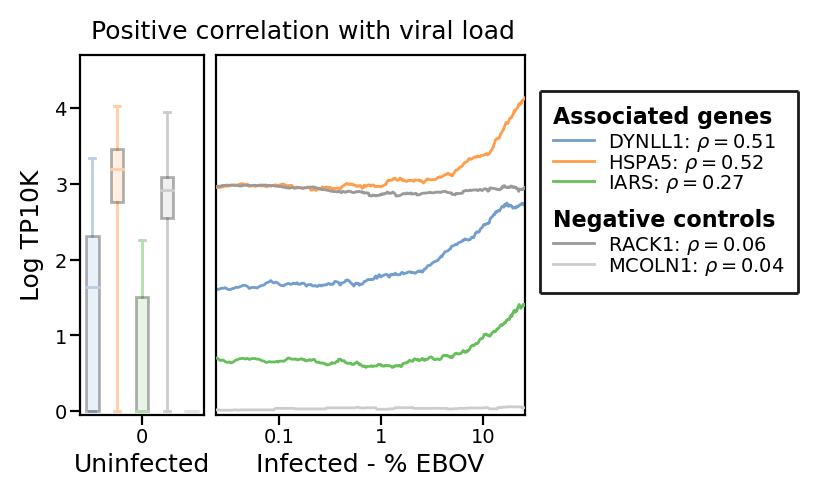

In [238]:
test_genes = ['DYNLL1','HSPA5', 'IARS']
control_genes = ['RACK1', 'MCOLN1']
control_colors=['.6', '.8']
control_colors=['.6', '.8']
test_colors = palettable.tableau.TableauMedium_10.hex_colors[:len(test_genes)]
minebov = log_percent_EBOV_windowed.min()
genes = control_genes + test_genes

fig = plt.figure(figsize=(fig_width,fig_height), dpi=200)
gs = gridspec.GridSpec(1, 3, figure=fig, left=left_space,
                       bottom=bottom_space, right=right_space, top=top_space,
                       wspace=wspace_frac,
                       width_ratios=[box_ax_width, line_ax_width, leg_ax_width],
                       hspace=0)

box_ax = fig.add_subplot(gs[0], xlim=[-.5, len(genes)-.5],
                     ylabel='Log TP10K', xlabel='',
                     title='')
line_ax = fig.add_subplot(gs[1],
                     ylabel='', xlabel='',
                     title='')

leg_ax = fig.add_subplot(gs[2],
                     ylabel='', xlabel='',
                     title='', frame_on=False,
                     xlim=[0,1], ylim=[0,1],
                     xticks=[], yticks=[])


leg_y_pos = np.linspace(0.8, .4, num=8, endpoint=True)
control_marker_y_pos = np.take(leg_y_pos,[6, 7])
test_marker_y_pos = np.take(leg_y_pos,[ 1, 2, 3])

leg_start_pos = .06
leg_marker_width = .16
marker_height = .04
text_offset = .05
leg_x_vals = np.array([leg_start_pos, leg_start_pos+leg_marker_width])
leg_ax.text(leg_start_pos, leg_y_pos[5]+.01, 'Negative controls', fontsize=8,
            fontweight='bold')
leg_ax.text(leg_start_pos, leg_y_pos[0]+.01, 'Associated genes', fontsize=8,
            fontweight='bold')
leg_ax.hlines(y=leg_y_pos[0]+.06+marker_height, xmin=0.01, xmax=.99, colors='.1', linewidth=1 )
leg_ax.hlines(y=leg_y_pos[-1]-.06, xmin=0.01, xmax=.99, colors='.1', linewidth=1 )
leg_ax.vlines(x=.01, ymin= leg_y_pos[-1]-.06, ymax=leg_y_pos[0]+.06+marker_height,
               colors='.1', linewidth=1 )
leg_ax.vlines(x=.99, ymin= leg_y_pos[-1]-.06, ymax=leg_y_pos[0]+.06+marker_height,
               colors='.1', linewidth=1 )

line_width = 1

zorder = 0
test_alpha=.9
box_xpos = 0
for (i,(g, primary_color)) in enumerate(zip(test_genes, test_colors)):
    fill_color = lighten_color(primary_color)
    '''
    line_ax.fill_between(log_percent_EBOV_windowed,
                    (plotdata_g0_windowed_mean[g]-plotdata_g0_windowed_se[g]),
                    (plotdata_g0_windowed_mean[g]+plotdata_g0_windowed_se[g]),
                    color=fill_color, alpha=test_alpha,
                    edgecolor='w', interpolate=False, step='mid', linewidth=0,
                    zorder=zorder)
    '''
    zorder += 1
    line_ax.plot(log_percent_EBOV_windowed, plotdata_g0_windowed_mean[g], color=primary_color, linewidth=line_width,
                 alpha=1, zorder = zorder)
    zorder += 1
    '''
    leg_ax.fill_between(leg_x_vals,
                        [test_marker_y_pos[i]]*2, [test_marker_y_pos[i]+marker_height]*2,
                    color=fill_color, alpha=test_alpha,
                    edgecolor='w', interpolate=False, step='mid', linewidth=0)
    '''
    leg_ax.plot([leg_x_vals[0],leg_x_vals[1]-.004] ,
                [test_marker_y_pos[i]+.5*marker_height]*2, color=primary_color, linewidth=line_width)
    leg_ax.text(leg_x_vals[1]+text_offset,test_marker_y_pos[i],
                g + ': ' + r'$\rho=$' + '%.2f' % (cont24.loc[g, 'Spearman_R']), fontsize=7)
    

    meanv = expr_0[g].median()
    top = expr_0[g].quantile(.9)
    bottom = expr_0[g].quantile(.1)

    bplot = box_ax.boxplot(list(expr_0[g]), positions=[box_xpos], patch_artist=True, whis=[2.5,97.5],
                    medianprops=dict(color=fill_color), showfliers=False, boxprops=dict(alpha=.3, facecolor=fill_color),
                    whiskerprops=dict(color=fill_color), capprops=dict(color=fill_color), widths=.5)
    box_xpos += 1


control_alpha=.7
box_xpos = 3
for (i,(g, primary_color)) in enumerate(zip(control_genes, control_colors)):
    fill_color = lighten_color(primary_color)
    '''
    line_ax.fill_between(log_percent_EBOV_windowed,
                    (plotdata_g0_windowed_mean[g]-plotdata_g0_windowed_se[g]),
                    (plotdata_g0_windowed_mean[g]+plotdata_g0_windowed_se[g]),
                    color=fill_color, alpha=control_alpha,
                    edgecolor='w', interpolate=False, step='mid', linewidth=0,
                    zorder=zorder)
    '''
    zorder+=1
    #line_ax.plot(log_percent_EBOV_windowed, plotdata_g0_windowed_mean[g], color='0', linewidth=line_width,
    #             zorder=zorder)
    line_ax.plot(log_percent_EBOV_windowed, plotdata_g0_windowed_mean[g], color=primary_color, linewidth=line_width,
                 zorder=zorder)
    zorder+=1
   

    '''
    leg_ax.fill_between(leg_x_vals,
                        [control_marker_y_pos[i]]*2, [control_marker_y_pos[i]+marker_height]*2,
                    color=fill_color, alpha=control_alpha,
                    edgecolor='w', interpolate=False, step='mid', linewidth=0)
    '''
    #leg_ax.plot([leg_x_vals[0],leg_x_vals[1]-.004] ,
    #            [control_marker_y_pos[i]+.5*marker_height]*2, color='0', linewidth=line_width)
    leg_ax.plot([leg_x_vals[0],leg_x_vals[1]-.004] ,
                [control_marker_y_pos[i]+.5*marker_height]*2, color=primary_color, linewidth=line_width)
    leg_ax.text(leg_x_vals[1]+text_offset,control_marker_y_pos[i],
                g + ': ' + r'$\rho=$' + '%.2f' % (cont24.loc[g, 'Spearman_R']), fontsize=7)
    
    meanv = expr_0[g].median()
    top = expr_0[g].quantile(.9)
    bottom = expr_0[g].quantile(.1)

    bplot = box_ax.boxplot(list(expr_0[g]), positions=[box_xpos], patch_artist=True, whis=[2.5,97.5],
                    medianprops=dict(color=fill_color), showfliers=False, boxprops=dict(alpha=.3, facecolor=fill_color),
                    whiskerprops=dict(color=fill_color), capprops=dict(color=fill_color), widths=.5)
    box_xpos += 1


box_ax.set_ylim([-.05,4.7])
line_ax.set_ylim(box_ax.get_ylim())
line_ax.set_yticks([])


#leg_ax.legend(loc=(0,.5), fontsize=7, title_fontsize=8, markerscale=(1/1000), framealpha=1)

line_ax.set_xticks([-2, -1, 0, 1, 2])
line_ax.set_xticklabels(['.01', '0.1', '1', '10', '100'])
line_ax.set_xlim([log_percent_EBOV_windowed.min(), log_percent_EBOV_windowed.max()])


merge_ax = fig.add_subplot(gs[:2], xticks=[], yticks=[], frameon=False,
                     ylabel='', xlabel='',
                     title='')
merge_ax.set_title('Positive correlation with viral load')
box_ax.set_xticks([2.])
box_ax.set_xticklabels(['0'])
box_ax.set_xlabel('Uninfected', labelpad=2, fontsize=9)
line_ax.set_xlabel('Infected - % EBOV', labelpad=2, fontsize=9)

box_ax.grid(False)
line_ax.grid(False)

figure_file = os.path.join(results_dir, "EBOVposCorrHostGenes.TrajectoryPlot.ExVivo.pdf")
fig.savefig(figure_file, dpi=200)

In [239]:
cont24.loc['FTH1', :]

primerid             FTH1
logFC            0.103151
P_H           2.45122e-05
P_C            4.0677e-06
P_D                     1
Q              0.00117517
logQ               2.9299
Spearman_R       0.237903
Spearman_P    6.58572e-07
ISG                 False
Category            Other
Name: FTH1, dtype: object

In [240]:
ind = (obs['animal']=='EV0004') 
expr_ev4 = expr.loc[ind,:]
obs_ev4 = obs.loc[ind,:]

g0ind = obs_ev4['percent_EBOV']>0

expr_g0_ev4 = expr_ev4.loc[g0ind,:]
expr_0_ev4 = expr_ev4.loc[~g0ind,:]
percent_ebov_ev4 = obs_ev4.loc[g0ind, 'percent_EBOV']*100

plotdata_g0_ev4 = pd.concat([percent_ebov_ev4, expr_g0_ev4], axis=1)
plotdata_g0_ev4 = plotdata_g0_ev4.sort_values(by='percent_EBOV', ascending=True)


windowsize=50
plotdata_g0_ev4_windowed_mean = plotdata_g0_ev4.rolling(window=windowsize, center=True).mean().dropna()
plotdata_g0_ev4_windowed_se = 1.96*(plotdata_g0_ev4.rolling(window=windowsize, center=True).std().dropna() / np.sqrt(windowsize))

percent_EBOV_ev4_windowed = plotdata_g0_ev4_windowed_mean['percent_EBOV']
log_percent_EBOV_ev4_windowed = percent_EBOV_ev4_windowed.apply(np.log10)

In [241]:
from scipy.stats import spearmanr

ev4_spearman = []
for g in expr_g0_ev4.columns:
    ev4_spearman.append(list(spearmanr(percent_ebov_ev4, expr_g0_ev4[g])))
ev4_spearman = pd.DataFrame(ev4_spearman, index=expr_g0_ev4.columns, columns=['EV4_Spearman_R', 'EV4_Spearman_P'])

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [242]:
ind = (obs['animal']=='EV0003') 
expr_ev3 = expr.loc[ind,:]
obs_ev3 = obs.loc[ind,:]

g0ind = obs['percent_EBOV']>0

expr_g0_ev3 = expr.loc[g0ind,:]
expr_0_ev3 = expr.loc[~g0ind,:]
percent_ebov_ev3 = obs.loc[g0ind, 'percent_EBOV']*100
animal = obs['animal']


plotdata_g0_ev3 = pd.concat([percent_ebov_ev3, expr_g0_ev3], axis=1)
plotdata_g0_ev3 = plotdata_g0_ev3.sort_values(by='percent_EBOV', ascending=True)


windowsize=50
plotdata_g0_ev3_windowed_mean = plotdata_g0_ev3.rolling(window=windowsize, center=True).mean().dropna()
plotdata_g0_ev3_windowed_se = 1.96*(plotdata_g0_ev3.rolling(window=windowsize, center=True).std().dropna() / np.sqrt(windowsize))

percent_EBOV_ev3_windowed = plotdata_g0_ev3_windowed_mean['percent_EBOV']
log_percent_EBOV_ev3_windowed = percent_EBOV_ev3_windowed.apply(np.log10)

In [243]:
ev3_spearman = []
for g in expr_g0_ev3.columns:
    ev3_spearman.append(list(spearmanr(percent_ebov_ev3, expr_g0_ev3[g])))
ev3_spearman = pd.DataFrame(ev3_spearman, index=expr_g0_ev3.columns, columns=['EV3_Spearman_R', 'EV3_Spearman_P'])

In [244]:
box_ax_width = .8
line_ax_width = 2
leg_ax_width = 1.7
ax_height = 1.8
ax_width = box_ax_width + line_ax_width + leg_ax_width
wspace_frac = .05
wspace = np.mean([box_ax_width, line_ax_width, leg_ax_width])*wspace_frac
right_space = .98
left_space = .1
top_space = .9
bottom_space = .13
fig_width = (ax_width+2*wspace)*(right_space - left_space)
fig_height = ax_height/(top_space-bottom_space)

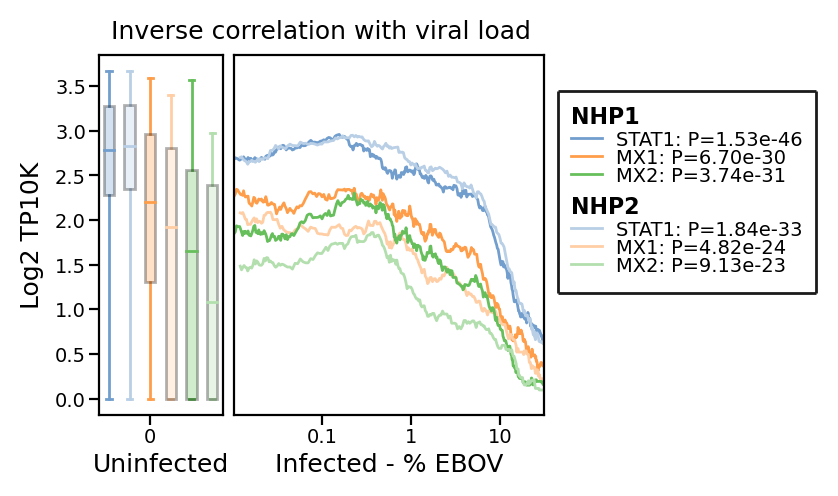

In [245]:
from matplotlib import gridspec

test_genes = ['STAT1', 'MX1', 'MX2']

test_colors_ev3 = palettable.tableau.TableauMedium_10.hex_colors[:len(test_genes)]
minebov = log_percent_EBOV_ev4_windowed.min()
genes = test_genes

fig = plt.figure(figsize=(fig_width,fig_height), dpi=200)
gs = gridspec.GridSpec(1, 3, figure=fig, left=left_space,
                       bottom=bottom_space, right=right_space, top=top_space,
                       wspace=wspace_frac,
                       width_ratios=[box_ax_width, line_ax_width, leg_ax_width],
                       hspace=0)

box_ax = fig.add_subplot(gs[0], xlim=[-.5, (len(genes)*2)-.5],
                     ylabel='Log2 TP10K', xlabel='',
                     title='')
line_ax = fig.add_subplot(gs[1],
                     ylabel='', xlabel='',
                     title='')

leg_ax = fig.add_subplot(gs[2],
                     ylabel='', xlabel='',
                     title='', frame_on=False,
                     xlim=[0,1], ylim=[0,1],
                     xticks=[], yticks=[])


leg_y_pos = np.linspace(0.8, .4, num=9, endpoint=True)
ev4_marker_y_pos = np.take(leg_y_pos,[6, 7, 8])
ev3_marker_y_pos = np.take(leg_y_pos,[ 1, 2, 3])

leg_start_pos = .06
leg_marker_width = .12
marker_height = .04
text_offset = .05
leg_x_vals = np.array([leg_start_pos, leg_start_pos+leg_marker_width])
leg_ax.text(leg_start_pos, leg_y_pos[0]+.01, 'NHP1', fontsize=8,
            fontweight='bold')
leg_ax.text(leg_start_pos, leg_y_pos[5]+.01, 'NHP2', fontsize=8,
            fontweight='bold')
leg_ax.hlines(y=leg_y_pos[0]+.06+marker_height, xmin=0.01, xmax=.99, colors='.1', linewidth=1 )
leg_ax.hlines(y=leg_y_pos[-1]-.06, xmin=0.01, xmax=.99, colors='.1', linewidth=1 )
leg_ax.vlines(x=.01, ymin= leg_y_pos[-1]-.06, ymax=leg_y_pos[0]+.06+marker_height,
               colors='.1', linewidth=1 )
leg_ax.vlines(x=.99, ymin= leg_y_pos[-1]-.06, ymax=leg_y_pos[0]+.06+marker_height,
               colors='.1', linewidth=1 )

line_width = 1

zorder = 0
test_alpha=.9
box_xpos = 0
for (i,(g, primary_color)) in enumerate(zip(test_genes, test_colors_ev3)):
    secondary_color = lighten_color(primary_color)
    line_ax.plot(log_percent_EBOV_ev3_windowed, plotdata_g0_ev3_windowed_mean[g], color=primary_color, linewidth=line_width,
                 alpha=1, zorder = zorder)   
    line_ax.plot(log_percent_EBOV_ev4_windowed, plotdata_g0_ev4_windowed_mean[g], color=secondary_color, linewidth=line_width,
                 alpha=1, zorder = zorder) 
    
    leg_ax.plot([leg_x_vals[0],leg_x_vals[1]-.004] ,
                [ev3_marker_y_pos[i]+.5*marker_height]*2, color=primary_color, linewidth=line_width)
    leg_ax.text(leg_x_vals[1]+text_offset,ev3_marker_y_pos[i],
                g + ': ' + r'P=' + '%.2e' % (ev3_spearman.loc[g, 'EV3_Spearman_P']), fontsize=7)
    
    leg_ax.plot([leg_x_vals[0],leg_x_vals[1]-.004] ,
                [ev4_marker_y_pos[i]+.5*marker_height]*2, color=secondary_color, linewidth=line_width)
    leg_ax.text(leg_x_vals[1]+text_offset,ev4_marker_y_pos[i],
                g + ': ' + r'P=' + '%.2e' % (ev4_spearman.loc[g, 'EV4_Spearman_P']), fontsize=7)
    
    
    bplot = box_ax.boxplot(list(expr_0_ev3[g]), positions=[box_xpos], patch_artist=True, whis=[2.5,97.5],
                    medianprops=dict(color=primary_color), showfliers=False, boxprops=dict(alpha=.3, facecolor=primary_color),
                    whiskerprops=dict(color=primary_color), capprops=dict(color=primary_color), widths=.5)

    bplot = box_ax.boxplot(list(expr_0_ev4[g]), positions=[box_xpos+1], patch_artist=True, whis=[2.5,97.5],
                    medianprops=dict(color=secondary_color), showfliers=False, boxprops=dict(alpha=.3, facecolor=secondary_color),
                    whiskerprops=dict(color=secondary_color), capprops=dict(color=secondary_color), widths=.5)
    box_xpos += 2










line_ax.set_ylim(box_ax.get_ylim())
line_ax.set_yticks([])

line_ax.set_xticks([-2, -1, 0, 1, 2])
line_ax.set_xticklabels(['.01', '0.1', '1', '10', '100'])
minv = min(log_percent_EBOV_ev3_windowed.min(), log_percent_EBOV_ev4_windowed.min())
maxv = min(log_percent_EBOV_ev3_windowed.max(), log_percent_EBOV_ev4_windowed.max())
line_ax.set_xlim([minv, maxv])


merge_ax = fig.add_subplot(gs[:2], xticks=[], yticks=[], frameon=False,
                     ylabel='', xlabel='',
                     title='')
merge_ax.set_title('Inverse correlation with viral load')
box_ax.set_xticks([2.])
box_ax.set_xticklabels(['0'])
box_ax.grid(False)
#box_ax.set_ylabel('Log2 TP10K', labelpad=2, fontsize=9)
line_ax.grid(False)

#box_ax.set_yticks([0, 2, 4, 6])

#box_ax.set_yticklabels(['0', '2', '4', '6'], fontsize=7)

box_ax.set_xlabel('Uninfected', labelpad=2)
line_ax.set_xlabel('Infected - % EBOV', labelpad=2)

figure_file = os.path.join(results_dir, "EBOVnegCorrHostGenes.TrajectoryPlot.PerAnimal.ExVivo.pdf")
fig.savefig(figure_file, dpi=200)

In [246]:
box_ax_width = .8
line_ax_width = 2
leg_ax_width = 1.8
ax_height = 1.8
ax_width = box_ax_width + line_ax_width + leg_ax_width
wspace_frac = .05
wspace = np.mean([box_ax_width, line_ax_width, leg_ax_width])*wspace_frac
right_space = .98
left_space = .1
top_space = .9
bottom_space = .13
fig_width = (ax_width+2*wspace)*(right_space - left_space)
fig_height = ax_height/(top_space-bottom_space)

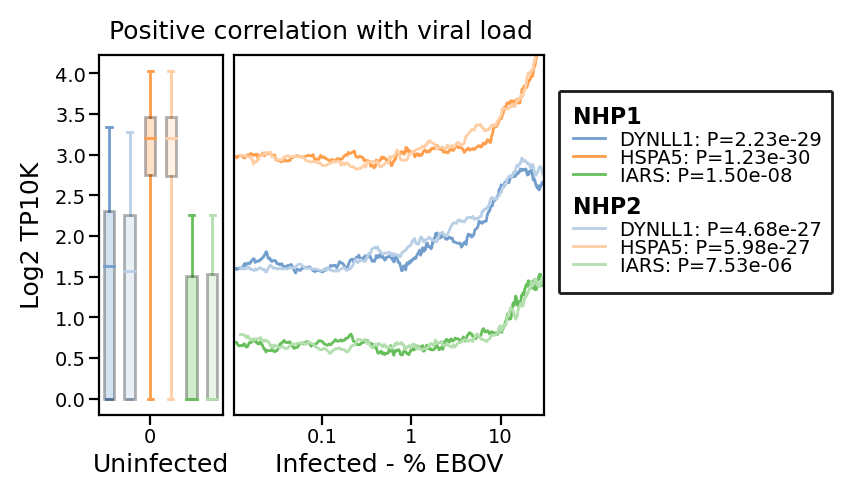

In [247]:
test_genes = ['DYNLL1','HSPA5', 'IARS']

test_colors_ev3 = palettable.tableau.TableauMedium_10.hex_colors[:len(test_genes)]
minebov = log_percent_EBOV_ev4_windowed.min()
genes = test_genes

fig = plt.figure(figsize=(fig_width,fig_height), dpi=200)
gs = gridspec.GridSpec(1, 3, figure=fig, left=left_space,
                       bottom=bottom_space, right=right_space, top=top_space,
                       wspace=wspace_frac,
                       width_ratios=[box_ax_width, line_ax_width, leg_ax_width],
                       hspace=0)

box_ax = fig.add_subplot(gs[0], xlim=[-.5, (len(genes)*2)-.5],
                     ylabel='Log2 TP10K', xlabel='',
                     title='')
line_ax = fig.add_subplot(gs[1],
                     ylabel='', xlabel='',
                     title='')

leg_ax = fig.add_subplot(gs[2],
                     ylabel='', xlabel='',
                     title='', frame_on=False,
                     xlim=[0,1], ylim=[0,1],
                     xticks=[], yticks=[])


leg_y_pos = np.linspace(0.8, .4, num=9, endpoint=True)
ev4_marker_y_pos = np.take(leg_y_pos,[6, 7, 8])
ev3_marker_y_pos = np.take(leg_y_pos,[ 1, 2, 3])

leg_start_pos = .06
leg_marker_width = .12
marker_height = .04
text_offset = .05
leg_x_vals = np.array([leg_start_pos, leg_start_pos+leg_marker_width])
leg_ax.text(leg_start_pos, leg_y_pos[0]+.01, 'NHP1', fontsize=8,
            fontweight='bold')
leg_ax.text(leg_start_pos, leg_y_pos[5]+.01, 'NHP2', fontsize=8,
            fontweight='bold')
leg_ax.hlines(y=leg_y_pos[0]+.06+marker_height, xmin=0.01, xmax=.99, colors='.1', linewidth=1 )
leg_ax.hlines(y=leg_y_pos[-1]-.06, xmin=0.01, xmax=.99, colors='.1', linewidth=1 )
leg_ax.vlines(x=.01, ymin= leg_y_pos[-1]-.06, ymax=leg_y_pos[0]+.06+marker_height,
               colors='.1', linewidth=1 )
leg_ax.vlines(x=.99, ymin= leg_y_pos[-1]-.06, ymax=leg_y_pos[0]+.06+marker_height,
               colors='.1', linewidth=1 )

line_width = 1

zorder = 0
test_alpha=.9
box_xpos = 0
for (i,(g, primary_color)) in enumerate(zip(test_genes, test_colors_ev3)):
    secondary_color = lighten_color(primary_color)
    line_ax.plot(log_percent_EBOV_ev3_windowed, plotdata_g0_ev3_windowed_mean[g], color=primary_color, linewidth=line_width,
                 alpha=1, zorder = zorder)   
    line_ax.plot(log_percent_EBOV_ev4_windowed, plotdata_g0_ev4_windowed_mean[g], color=secondary_color, linewidth=line_width,
                 alpha=1, zorder = zorder) 
    
    leg_ax.plot([leg_x_vals[0],leg_x_vals[1]-.004] ,
                [ev3_marker_y_pos[i]+.5*marker_height]*2, color=primary_color, linewidth=line_width)
    leg_ax.text(leg_x_vals[1]+text_offset,ev3_marker_y_pos[i],
                g + ': ' + r'P=' + '%.2e' % (ev3_spearman.loc[g, 'EV3_Spearman_P']), fontsize=7)
    
    leg_ax.plot([leg_x_vals[0],leg_x_vals[1]-.004] ,
                [ev4_marker_y_pos[i]+.5*marker_height]*2, color=secondary_color, linewidth=line_width)
    leg_ax.text(leg_x_vals[1]+text_offset,ev4_marker_y_pos[i],
                g + ': ' + r'P=' + '%.2e' % (ev4_spearman.loc[g, 'EV4_Spearman_P']), fontsize=7)
    
    
    bplot = box_ax.boxplot(list(expr_0_ev3[g]), positions=[box_xpos], patch_artist=True, whis=[2.5,97.5],
                    medianprops=dict(color=primary_color), showfliers=False, boxprops=dict(alpha=.3, facecolor=primary_color),
                    whiskerprops=dict(color=primary_color), capprops=dict(color=primary_color), widths=.5)

    bplot = box_ax.boxplot(list(expr_0_ev4[g]), positions=[box_xpos+1], patch_artist=True, whis=[2.5,97.5],
                    medianprops=dict(color=secondary_color), showfliers=False, boxprops=dict(alpha=.3, facecolor=secondary_color),
                    whiskerprops=dict(color=secondary_color), capprops=dict(color=secondary_color), widths=.5)
    box_xpos += 2










line_ax.set_ylim(box_ax.get_ylim())
line_ax.set_yticks([])

line_ax.set_xticks([-2, -1, 0, 1, 2])
line_ax.set_xticklabels(['.01', '0.1', '1', '10', '100'])
minv = min(log_percent_EBOV_ev3_windowed.min(), log_percent_EBOV_ev4_windowed.min())
maxv = min(log_percent_EBOV_ev3_windowed.max(), log_percent_EBOV_ev4_windowed.max())
line_ax.set_xlim([minv, maxv])


merge_ax = fig.add_subplot(gs[:2], xticks=[], yticks=[], frameon=False,
                     ylabel='', xlabel='',
                     title='')
merge_ax.set_title('Positive correlation with viral load')
box_ax.set_xticks([2.])
box_ax.set_xticklabels(['0'])
box_ax.grid(False)
#box_ax.set_ylabel('Log2 TP10K', labelpad=2, fontsize=9)
line_ax.grid(False)
#box_ax.set_yticks([0, 2, 4, 6])

#box_ax.set_yticklabels(['0', '2', '4', '6'], fontsize=7)

box_ax.set_xlabel('Uninfected', labelpad=2)
line_ax.set_xlabel('Infected - % EBOV', labelpad=2)
figure_file = os.path.join(results_dir, "EBOVposCorrHostGenes.TrajectoryPlot.PerAnimal.ExVivo.pdf")
fig.savefig(figure_file, dpi=200)

## Make EBOV trajectory plot

In [248]:
adata_raw_wEBOV = sc.AnnData(X=adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)


In [249]:
metadata = adata_raw_wEBOV.obs
infectedcells = metadata.index[(metadata['Ebola_Positive']==True) & metadata['condition'].isin(['live.H024', 'live.H004'])  & (metadata['SubclusteringGroup']=='Mono')]
geneorder = ['EBOV-NP', 'EBOV-VP35','EBOV-VP40', 'EBOV-GP','EBOV-VP30', 'EBOV-VP24', 'EBOV-L']
exvivo_ebov_data = pd.DataFrame(adata_raw_wEBOV[:,geneorder].X.todense(), index=adata_raw_wEBOV.obs.index, columns=geneorder)

In [250]:
numwindow = 50

exvivo_ebov_data_toplot = pd.concat([exvivo_ebov_data.loc[infectedcells, geneorder], metadata.loc[infectedcells, ['percent_EBOV']]], axis=1)
exvivo_ebov_data_toplot = exvivo_ebov_data_toplot.sort_values(by='percent_EBOV')
ebov_pos_data_combined_windowed = exvivo_ebov_data_toplot.rolling(window=numwindow, center=True, win_type='triang').sum()
ebov_pos_data_combined_windowed_mean = exvivo_ebov_data_toplot.rolling(window=numwindow, center=True, win_type='triang').mean()
ebov_pos_data_combined_windowed['percent_EBOV'] = ebov_pos_data_combined_windowed_mean['percent_EBOV']*100
ebov_pos_data_combined_windowed = ebov_pos_data_combined_windowed.dropna()
ebov_pos_data_combined_windowed_norm = ebov_pos_data_combined_windowed.copy()


X = ebov_pos_data_combined_windowed_norm.iloc[:,:-1].copy()
P = X.div(X.sum(axis=1), axis=0)
ebov_pos_data_combined_windowed_norm.iloc[:,:-1] = P

ebov_pos_data_combined_windowed_norm_SE = (P*(1-P)).div(X.sum(axis=1), axis=0)
ebov_pos_data_combined_windowed_norm_SE = ebov_pos_data_combined_windowed_norm_SE.apply(np.sqrt) #*1.96

ebov_pos_data_combined_windowed_norm_SE['percent_EBOV'] = ebov_pos_data_combined_windowed_norm['percent_EBOV']

ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'] = ebov_pos_data_combined_windowed_norm['percent_EBOV'].apply(np.log10)
ebov_pos_data_combined_windowed_norm_SE['log10_percent_EBOV'] = ebov_pos_data_combined_windowed_norm_SE['percent_EBOV'].apply(np.log10)

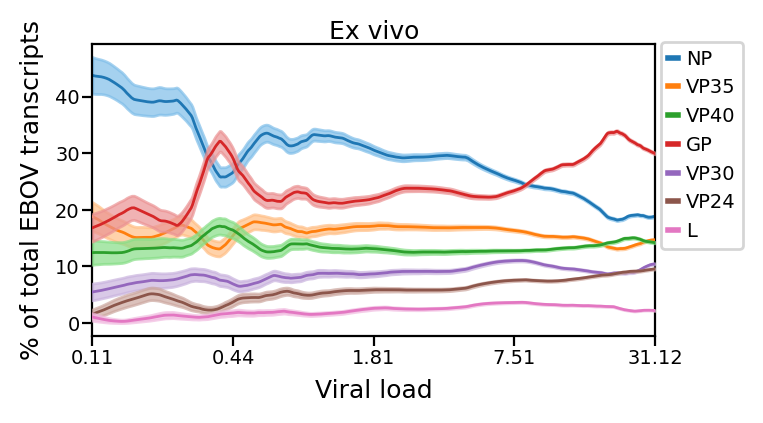

In [251]:
fig = plt.figure(constrained_layout=True, figsize=(3.7,2), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.8, top=.9)
ax = fig.add_subplot(gs[0])

quantile = ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'].quantile([0, .25, .5, .75, 1])

zorder=0
for (i,g) in enumerate(geneorder):
    fillcolor = lighten_color(palettable.tableau.Tableau_10.mpl_colors[i], amount=.5)
    ax.fill_between(ebov_pos_data_combined_windowed_norm_SE['log10_percent_EBOV'],
                    (ebov_pos_data_combined_windowed_norm[g]-ebov_pos_data_combined_windowed_norm_SE[g])*100,
                    (ebov_pos_data_combined_windowed_norm[g]+ebov_pos_data_combined_windowed_norm_SE[g])*100,
                    color=fillcolor, alpha=0.7,
                    edgecolor=palettable.tableau.Tableau_10.mpl_colors[i],
                    zorder=zorder)
    zorder+=1

    ax.plot(ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'], ebov_pos_data_combined_windowed_norm[g]*100,
               color=palettable.tableau.Tableau_10.mpl_colors[i],
            label=g.split('-')[1], linewidth=1,
                    zorder=zorder)
    zorder+=1
    
    
    
    #ax.plot(ebov_pos_data_combined_windowed_norm['percent_EBOV_scale'], ebov_pos_data_combined_windowed_norm[g]*100,
    #           color='k', label=None, linewidth=.1)
    
leg = ax.legend(fontsize=7, loc=(1.01,0.3), markerscale=1)
ax.set_xlabel('Viral load')
ax.set_ylabel('% of total EBOV transcripts')
#ax.set_title('Ebola transcript abundance over life-cycle')

for line in leg.get_lines():
    line.set_linewidth(2.0)

xmin=ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'].min()
xmax=ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'].max()
vals = np.logspace(start=xmin, stop=xmax, num=5, endpoint=True, base=10)
#vals = [ 0.05618414,  0.27915831,  1.38703487,  6.89166563, 34.24214936]
pos = [np.log10(x) for x in vals]


ax.set_xticks(pos)
ax.set_xticklabels(['%.2f' % x for x in vals])
ax.set_xlim([pos[0], pos[-1]])
ax.set_title('Ex vivo', pad=0)
ax.grid(False)

figure_file = os.path.join(results_dir, "EbolaGenePercentage.ExVivo.Line.pdf")
fig.savefig(figure_file, dpi=200)

In [252]:
metadata.head()

,batch,array_id,run,BP,treatment_full,treatment,MOI,animal,hour,condition,...,percent_hbb,leiden,leiden_lab,leiden_lab_group,Subclustering,SubclusteringGroup,Doublet,Soup_Usage,ebola_infection_threshold,Ebola_Positive
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAAAATGCC,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,0.0,14,Mono/DC 1,Mono/DC,Mono 2,Mono,False,0.001773,1,False
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTCGTGGT,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,0.0,0,Th 1,Th,Th_ITGB1lo_SELLhi 2,Th_ITGB1lo_SELLhi,False,0.039863,1,False
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTGCCTTG,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,0.0,4,Tc 1,Tc,Th_CXCR5hi 1,Th_CXCR5hi,False,0.076008,2,False
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAATCATTCTC,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,0.0,13,B 5,B,B_Naive 2,B_Naive,False,0.042099,1,False
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAACACTATTTT,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,0.0,6,B 1,B,B_Memory 2,B_Memory,False,0.036605,1,False


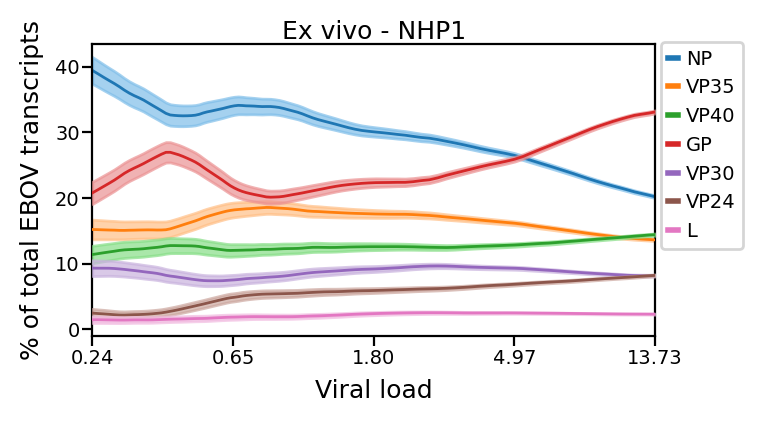

In [258]:
metadata = adata_raw_wEBOV.obs
infectedcells = metadata.index[(metadata['Ebola_Positive']==True) & metadata['condition'].isin(['live.H024', 'live.H004'])  & (metadata['SubclusteringGroup']=='Mono') & (metadata['animal']=='EV0003')]
geneorder = ['EBOV-NP', 'EBOV-VP35','EBOV-VP40', 'EBOV-GP','EBOV-VP30', 'EBOV-VP24', 'EBOV-L']
exvivo_ebov_data = pd.DataFrame(adata_raw_wEBOV[:,geneorder].X.todense(), index=adata_raw_wEBOV.obs.index, columns=geneorder)

numwindow = 50

exvivo_ebov_data_toplot = pd.concat([exvivo_ebov_data.loc[infectedcells, geneorder], metadata.loc[infectedcells, ['percent_EBOV']]], axis=1)
exvivo_ebov_data_toplot = exvivo_ebov_data_toplot.sort_values(by='percent_EBOV')
ebov_pos_data_combined_windowed = exvivo_ebov_data_toplot.rolling(window=numwindow, center=True, win_type='triang').sum()
ebov_pos_data_combined_windowed_mean = exvivo_ebov_data_toplot.rolling(window=numwindow, center=True, win_type='triang').mean()
ebov_pos_data_combined_windowed['percent_EBOV'] = ebov_pos_data_combined_windowed_mean['percent_EBOV']*100
ebov_pos_data_combined_windowed = ebov_pos_data_combined_windowed.dropna()
ebov_pos_data_combined_windowed_norm = ebov_pos_data_combined_windowed.copy()


X = ebov_pos_data_combined_windowed_norm.iloc[:,:-1].copy()
P = X.div(X.sum(axis=1), axis=0)
ebov_pos_data_combined_windowed_norm.iloc[:,:-1] = P

ebov_pos_data_combined_windowed_norm_SE = (P*(1-P)).div(X.sum(axis=1), axis=0)
ebov_pos_data_combined_windowed_norm_SE = ebov_pos_data_combined_windowed_norm_SE.apply(np.sqrt) #*1.96

ebov_pos_data_combined_windowed_norm_SE['percent_EBOV'] = ebov_pos_data_combined_windowed_norm['percent_EBOV']

ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'] = ebov_pos_data_combined_windowed_norm['percent_EBOV'].apply(np.log10)
ebov_pos_data_combined_windowed_norm_SE['log10_percent_EBOV'] = ebov_pos_data_combined_windowed_norm_SE['percent_EBOV'].apply(np.log10)

fig = plt.figure(constrained_layout=True, figsize=(3.7,2), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.8, top=.9)
ax = fig.add_subplot(gs[0])

quantile = ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'].quantile([0, .25, .5, .75, 1])

zorder=0
for (i,g) in enumerate(geneorder):
    fillcolor = lighten_color(palettable.tableau.Tableau_10.mpl_colors[i], amount=.5)
    ax.fill_between(ebov_pos_data_combined_windowed_norm_SE['log10_percent_EBOV'],
                    (ebov_pos_data_combined_windowed_norm[g]-ebov_pos_data_combined_windowed_norm_SE[g])*100,
                    (ebov_pos_data_combined_windowed_norm[g]+ebov_pos_data_combined_windowed_norm_SE[g])*100,
                    color=fillcolor, alpha=0.7,
                    edgecolor=palettable.tableau.Tableau_10.mpl_colors[i],
                    zorder=zorder)
    zorder+=1

    ax.plot(ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'], ebov_pos_data_combined_windowed_norm[g]*100,
               color=palettable.tableau.Tableau_10.mpl_colors[i],
            label=g.split('-')[1], linewidth=1,
                    zorder=zorder)
    zorder+=1
    
    
    
    #ax.plot(ebov_pos_data_combined_windowed_norm['percent_EBOV_scale'], ebov_pos_data_combined_windowed_norm[g]*100,
    #           color='k', label=None, linewidth=.1)
    
leg = ax.legend(fontsize=7, loc=(1.01,0.3), markerscale=1)
ax.set_xlabel('Viral load')
ax.set_ylabel('% of total EBOV transcripts')
#ax.set_title('Ebola transcript abundance over life-cycle')

for line in leg.get_lines():
    line.set_linewidth(2.0)

xmin=ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'].min()
xmax=ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'].max()
vals = np.logspace(start=xmin, stop=xmax, num=5, endpoint=True, base=10)
#vals = [ 0.05618414,  0.27915831,  1.38703487,  6.89166563, 34.24214936]
pos = [np.log10(x) for x in vals]


ax.set_xticks(pos)
ax.set_xticklabels(['%.2f' % x for x in vals])
ax.set_xlim([pos[0], pos[-1]])
ax.set_title('Ex vivo - NHP1', pad=0)
ax.grid(False)

figure_file = os.path.join(results_dir, "EbolaGenePercentage.ExVivo.NHP1.Line.pdf")
fig.savefig(figure_file, dpi=200)

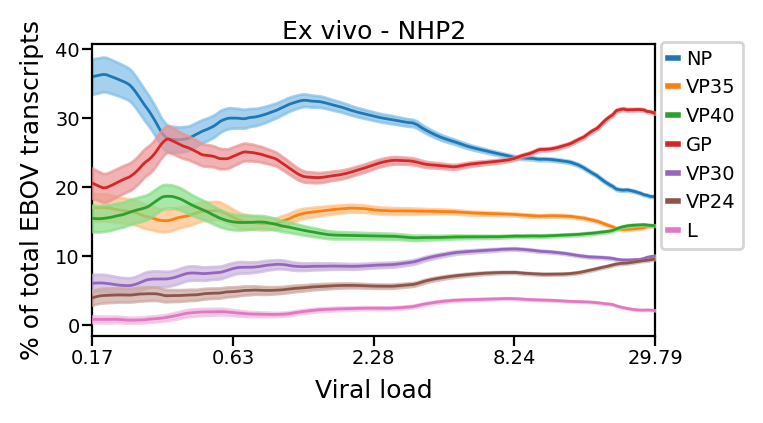

In [259]:
metadata = adata_raw_wEBOV.obs
infectedcells = metadata.index[(metadata['Ebola_Positive']==True) & metadata['condition'].isin(['live.H024', 'live.H004'])  & (metadata['SubclusteringGroup']=='Mono') & (metadata['animal']=='EV0004')]
geneorder = ['EBOV-NP', 'EBOV-VP35','EBOV-VP40', 'EBOV-GP','EBOV-VP30', 'EBOV-VP24', 'EBOV-L']
exvivo_ebov_data = pd.DataFrame(adata_raw_wEBOV[:,geneorder].X.todense(), index=adata_raw_wEBOV.obs.index, columns=geneorder)

numwindow = 50

exvivo_ebov_data_toplot = pd.concat([exvivo_ebov_data.loc[infectedcells, geneorder], metadata.loc[infectedcells, ['percent_EBOV']]], axis=1)
exvivo_ebov_data_toplot = exvivo_ebov_data_toplot.sort_values(by='percent_EBOV')
ebov_pos_data_combined_windowed = exvivo_ebov_data_toplot.rolling(window=numwindow, center=True, win_type='triang').sum()
ebov_pos_data_combined_windowed_mean = exvivo_ebov_data_toplot.rolling(window=numwindow, center=True, win_type='triang').mean()
ebov_pos_data_combined_windowed['percent_EBOV'] = ebov_pos_data_combined_windowed_mean['percent_EBOV']*100
ebov_pos_data_combined_windowed = ebov_pos_data_combined_windowed.dropna()
ebov_pos_data_combined_windowed_norm = ebov_pos_data_combined_windowed.copy()


X = ebov_pos_data_combined_windowed_norm.iloc[:,:-1].copy()
P = X.div(X.sum(axis=1), axis=0)
ebov_pos_data_combined_windowed_norm.iloc[:,:-1] = P

ebov_pos_data_combined_windowed_norm_SE = (P*(1-P)).div(X.sum(axis=1), axis=0)
ebov_pos_data_combined_windowed_norm_SE = ebov_pos_data_combined_windowed_norm_SE.apply(np.sqrt) #*1.96

ebov_pos_data_combined_windowed_norm_SE['percent_EBOV'] = ebov_pos_data_combined_windowed_norm['percent_EBOV']

ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'] = ebov_pos_data_combined_windowed_norm['percent_EBOV'].apply(np.log10)
ebov_pos_data_combined_windowed_norm_SE['log10_percent_EBOV'] = ebov_pos_data_combined_windowed_norm_SE['percent_EBOV'].apply(np.log10)

fig = plt.figure(constrained_layout=True, figsize=(3.7,2), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.8, top=.9)
ax = fig.add_subplot(gs[0])

quantile = ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'].quantile([0, .25, .5, .75, 1])

zorder=0
for (i,g) in enumerate(geneorder):
    fillcolor = lighten_color(palettable.tableau.Tableau_10.mpl_colors[i], amount=.5)
    ax.fill_between(ebov_pos_data_combined_windowed_norm_SE['log10_percent_EBOV'],
                    (ebov_pos_data_combined_windowed_norm[g]-ebov_pos_data_combined_windowed_norm_SE[g])*100,
                    (ebov_pos_data_combined_windowed_norm[g]+ebov_pos_data_combined_windowed_norm_SE[g])*100,
                    color=fillcolor, alpha=0.7,
                    edgecolor=palettable.tableau.Tableau_10.mpl_colors[i],
                    zorder=zorder)
    zorder+=1

    ax.plot(ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'], ebov_pos_data_combined_windowed_norm[g]*100,
               color=palettable.tableau.Tableau_10.mpl_colors[i],
            label=g.split('-')[1], linewidth=1,
                    zorder=zorder)
    zorder+=1
    
    
    
    #ax.plot(ebov_pos_data_combined_windowed_norm['percent_EBOV_scale'], ebov_pos_data_combined_windowed_norm[g]*100,
    #           color='k', label=None, linewidth=.1)
    
leg = ax.legend(fontsize=7, loc=(1.01,0.3), markerscale=1)
ax.set_xlabel('Viral load')
ax.set_ylabel('% of total EBOV transcripts')
#ax.set_title('Ebola transcript abundance over life-cycle')

for line in leg.get_lines():
    line.set_linewidth(2.0)

xmin=ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'].min()
xmax=ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'].max()
vals = np.logspace(start=xmin, stop=xmax, num=5, endpoint=True, base=10)
#vals = [ 0.05618414,  0.27915831,  1.38703487,  6.89166563, 34.24214936]
pos = [np.log10(x) for x in vals]


ax.set_xticks(pos)
ax.set_xticklabels(['%.2f' % x for x in vals])
ax.set_xlim([pos[0], pos[-1]])
ax.set_title('Ex vivo - NHP2', pad=0)
ax.grid(False)

figure_file = os.path.join(results_dir, "EbolaGenePercentage.ExVivo.NHP2.Line.pdf")
fig.savefig(figure_file, dpi=200)

In [166]:
cset = palettable.tableau.GreenOrange_12.hex_colors

condition_cmap = {'Live 24H':cset[2], 'Live 4H':cset[3], 'Irrad 24H':cset[4],  'Irrad 4H':cset[5], 'Media 24H':cset[0], 'Media 4H':cset[1]}

In [167]:
exvivo_ebov_data.head()

,EBOV-NP,EBOV-VP35,EBOV-VP40,EBOV-GP,EBOV-VP30,EBOV-VP24,EBOV-L
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAAAATGCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTCGTGGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTGCCTTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAATCATTCTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAACACTATTTT,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
metadata.head().T

,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAAAATGCC,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTCGTGGT,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTGCCTTG,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAATCATTCTC,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAACACTATTTT
batch,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...
array_id,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1
run,Novaseq_20190829,Novaseq_20190829,Novaseq_20190829,Novaseq_20190829,Novaseq_20190829
BP,88,88,88,88,88
treatment_full,irrad-moi1e-1,irrad-moi1e-1,irrad-moi1e-1,irrad-moi1e-1,irrad-moi1e-1
treatment,irrad,irrad,irrad,irrad,irrad
MOI,0.1,0.1,0.1,0.1,0.1
animal,EV0003,EV0003,EV0003,EV0003,EV0003
hour,H004,H004,H004,H004,H004
condition,irrad.H004,irrad.H004,irrad.H004,irrad.H004,irrad.H004


In [196]:
ebola_genes = ['EBOV-GENOME', 'EBOV-NP', 'EBOV-VP35', 'EBOV-VP40', 'EBOV-GP', 'EBOV-VP30', 'EBOV-VP24', 'EBOV-L']
exvivo_ebov_data = pd.DataFrame(adata_raw_wEBOV[:,ebola_genes].X.todense(), index=adata_raw_wEBOV.obs.index, columns=ebola_genes)

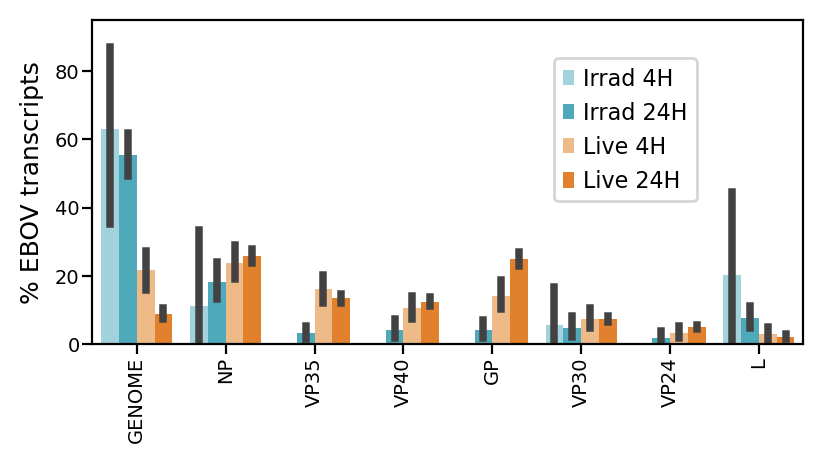

In [197]:
metadata['sample_treatment_clean'] = metadata['condition'].astype(str).apply(lambda x: x.replace('irrad','Irrad').replace('live','Live').replace('.H00', ' ').replace('.H0', ' '))+'H'


#ind = (metadata['SubclusteringGroup']=='Mono') & (metadata['Ebola_Positive'])
ind = (metadata['SubclusteringGroup']=='Mono') & (metadata['EBOV_counts']>0)

exvivo_ebov_data_infmono = exvivo_ebov_data.loc[ind,:]
metadata_infmono = metadata.loc[ind,:]



exvivo_ebov_data_infmono = exvivo_ebov_data_infmono.div(exvivo_ebov_data_infmono.sum(axis=1), axis=0)



exvivo_ebov_data_flat = exvivo_ebov_data_infmono.unstack().reset_index()
exvivo_ebov_data_flat.columns = ['gene', 'cell', '%']
exvivo_ebov_data_flat = pd.merge(left=exvivo_ebov_data_flat,
                                 right=metadata_infmono['sample_treatment_clean'],
                                 left_on='cell', right_index=True, how='left')

exvivo_ebov_data_flat['%'] *= 100
fig = plt.figure(constrained_layout=True, figsize=(4,2.2), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.8, top=.9)
ax = fig.add_subplot(gs[0])

hue_order = ['Irrad 4H', 'Irrad 24H', 'Live 4H', 'Live 24H']
sns.barplot(x='gene', y='%', hue='sample_treatment_clean', data=exvivo_ebov_data_flat,
            ax=ax, order=ebola_genes, hue_order=hue_order, palette=condition_cmap)
ax.set_xticklabels([x.split('-')[1] for x in ebola_genes], rotation=90)
ax.legend(title=False, fontsize=8, loc=(.65,.44))
ax.set_xlabel('')
ax.set_ylabel('% EBOV transcripts')
ax.set_ylim([0,95])
ax.grid(False)

figure_file = os.path.join(results_dir, "EbolaGenePercentage.PerCondition.ExVivo.Bar.pdf")
fig.savefig(figure_file, dpi=200)

In [224]:
100-exvivo_ebov_data_flat.groupby(['sample_treatment_clean', 'gene'])['%'].mean().xs('EBOV-GENOME', level=1)

sample_treatment_clean
Irrad 24H     44.522041
Irrad 4H      37.037037
Live 24H      91.167870
Live 4H       78.318855
media 24H    100.000000
media 4H      44.444443
Name: %, dtype: float32

In [208]:
ind = (metadata['SubclusteringGroup']=='Mono') & (metadata['EBOV_counts']>0)
sub_ebov = exvivo_ebov_data.loc[ind,:]
sub_meta = metadata.loc[ind,:]

sum = sub_ebov.groupby(sub_meta['condition']).sum()
sumnorm = sum.div(sum.sum(axis=1), axis=0)
1-sumnorm['EBOV-GENOME']

condition
irrad.H004    0.384615
irrad.H024    0.513915
live.H004     0.927561
live.H024     0.951326
media.H004    0.625000
media.H024    1.000000
Name: EBOV-GENOME, dtype: float32